In [ ]:
# SEAS 6414 HW8
# This homework focuses on analyzing and forecasting merchant transaction data using
# various time series techniques. The primary objective is to apply different forecasting
# models and evaluate their performance in predicting future transaction volumes.


In [201]:
cd C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8

C:\Users\1126692\Desktop\Desktop Files\Papers\GWU PhD\Python Lectures\Lecture8


In [202]:
pwd

'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'

In [430]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [320]:
# Read the data from CSV
# Sets the "time" column as the index. With parse_dates=True argument ensuring dates are parsed correctly
#df = pd.read_csv("homework8.csv", index_col="time", parse_dates=True)
df = pd.read_csv("homework8.csv", index_col=["time"], parse_dates=["time"])
df.head(10)

# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")]

# Resample data to daily transaction sums
daily_transactions = df.resample("D")["amount_usd_in_cents"].sum()/100  # Converted from cents to Dollars

# Print the resulting DataFrame (optional)
print("Daily Transactions in US Dollars:",daily_transactions.head())

# Save the resampled data (optional)
daily_transactions.to_csv("daily_transactions.csv")

Daily Transactions in US Dollars: time
2033-01-01     4415.40
2033-01-02     4758.62
2033-01-03     6283.53
2033-01-04     4851.11
2033-01-05    10016.21
Freq: D, Name: amount_usd_in_cents, dtype: float64


In [431]:
type(daily_transactions)


pandas.core.series.Series

In [432]:
df.head()

,Unnamed: 0,merchant,amount_usd_in_cents
time,,,
2034-06-17 23:34:14,1,faa029c6b0,6349
2034-12-27 00:40:38,2,ed7a7d91aa,3854
2034-04-30 01:29:42,3,5608f200cf,789
2034-09-16 01:06:23,4,15b1a0d61e,4452
2034-07-22 16:21:42,5,4770051790,20203


In [433]:
# Import extra libraries
# dataframe opertations - pandas
import pandas as pd
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

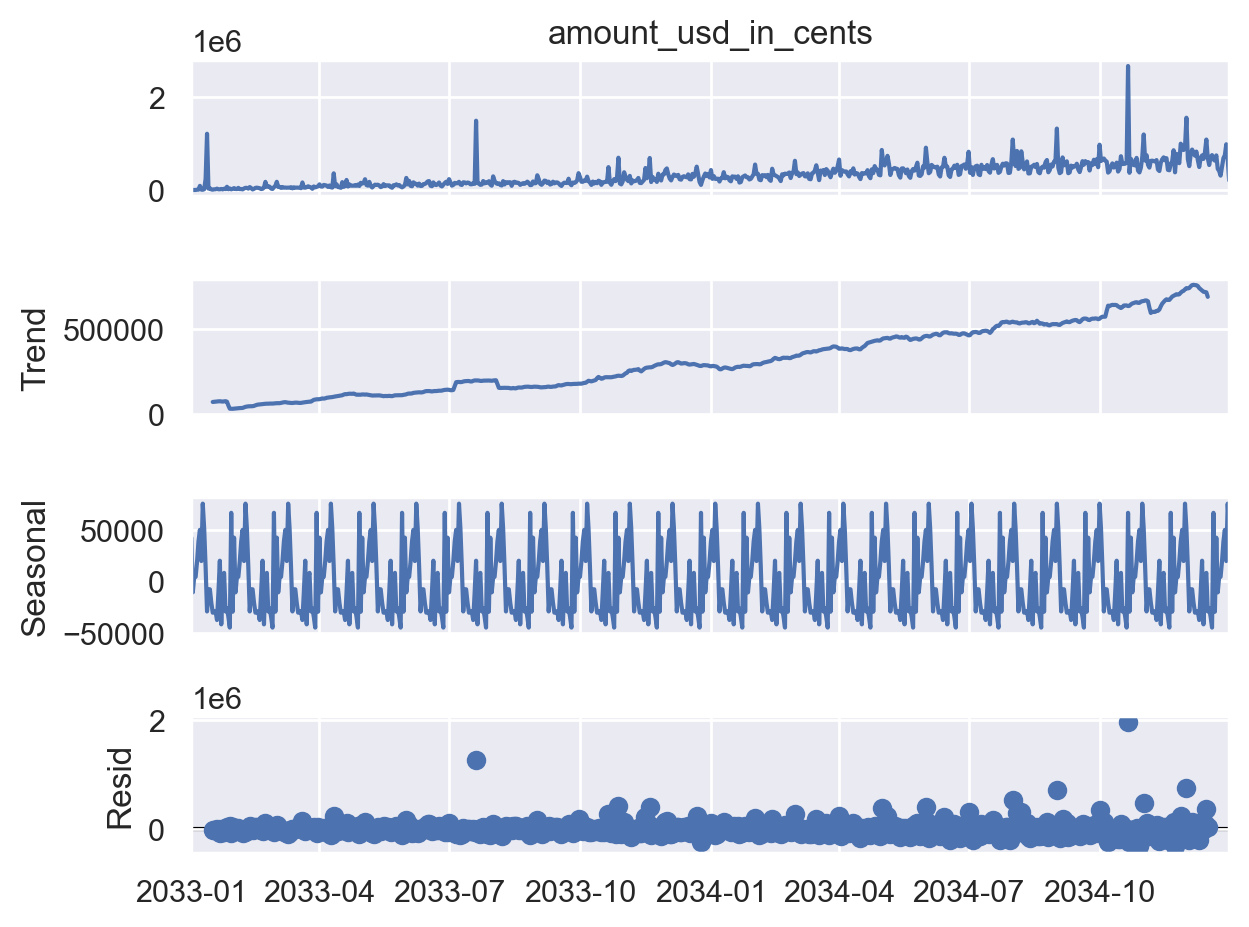

In [434]:
data = pd.read_csv('daily_transactions.csv', index_col ='time', parse_dates=True) # There is easier way to do this
#data = df.resample("D")["amount_usd_in_cents"].sum()  # Assuming "amount" is your transaction column


decompose_result = seasonal_decompose(data['amount_usd_in_cents'],period=30)
decompose_result.plot(); # Plotting Seasonality and Trend of Raw Data Only

In [435]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values (Dollars)")
    plt.legend(loc="upper left")
    plt.grid(True)

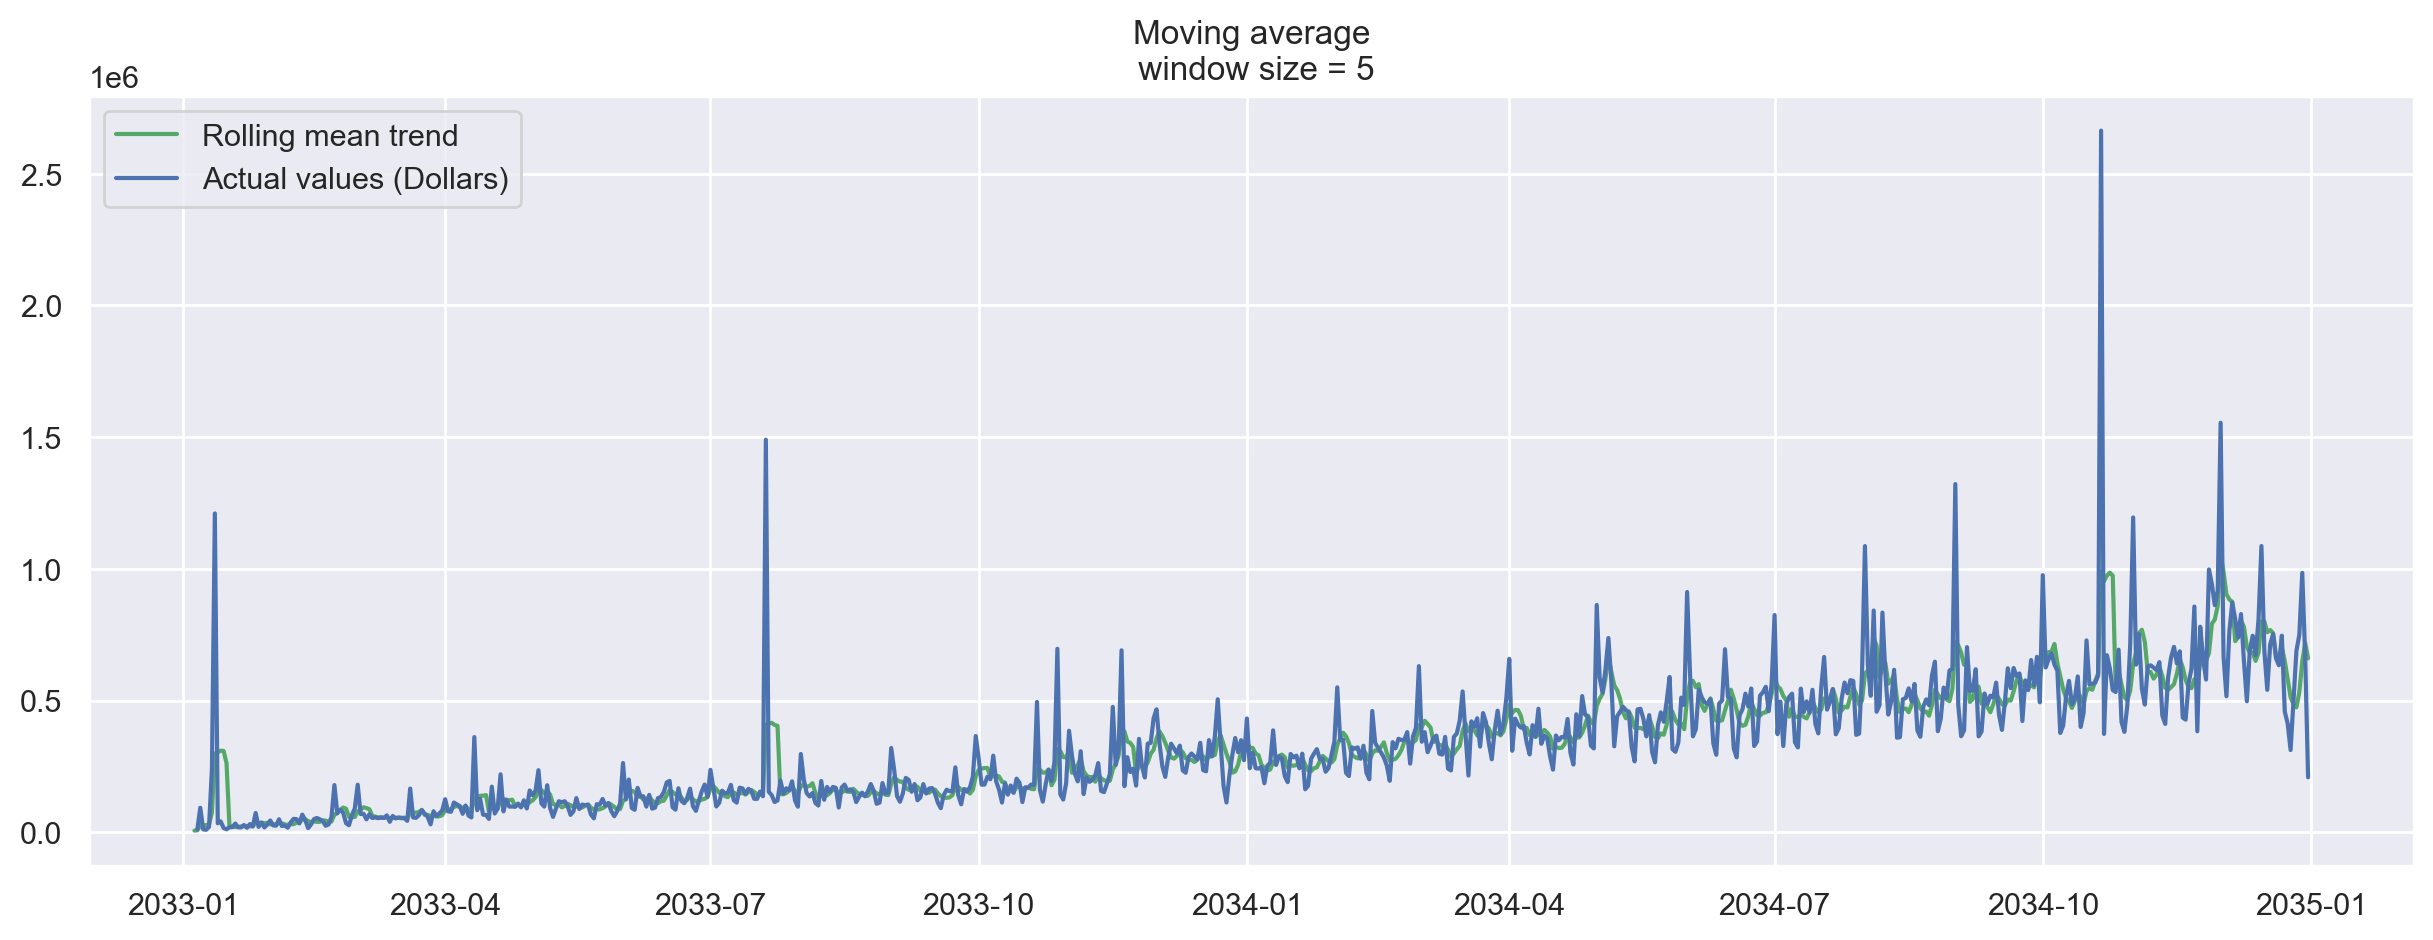

In [254]:
    Dollar_series = df.resample("D")["amount_usd_in_cents"].sum()/100
    plotMovingAverage(Dollar_series, 5)

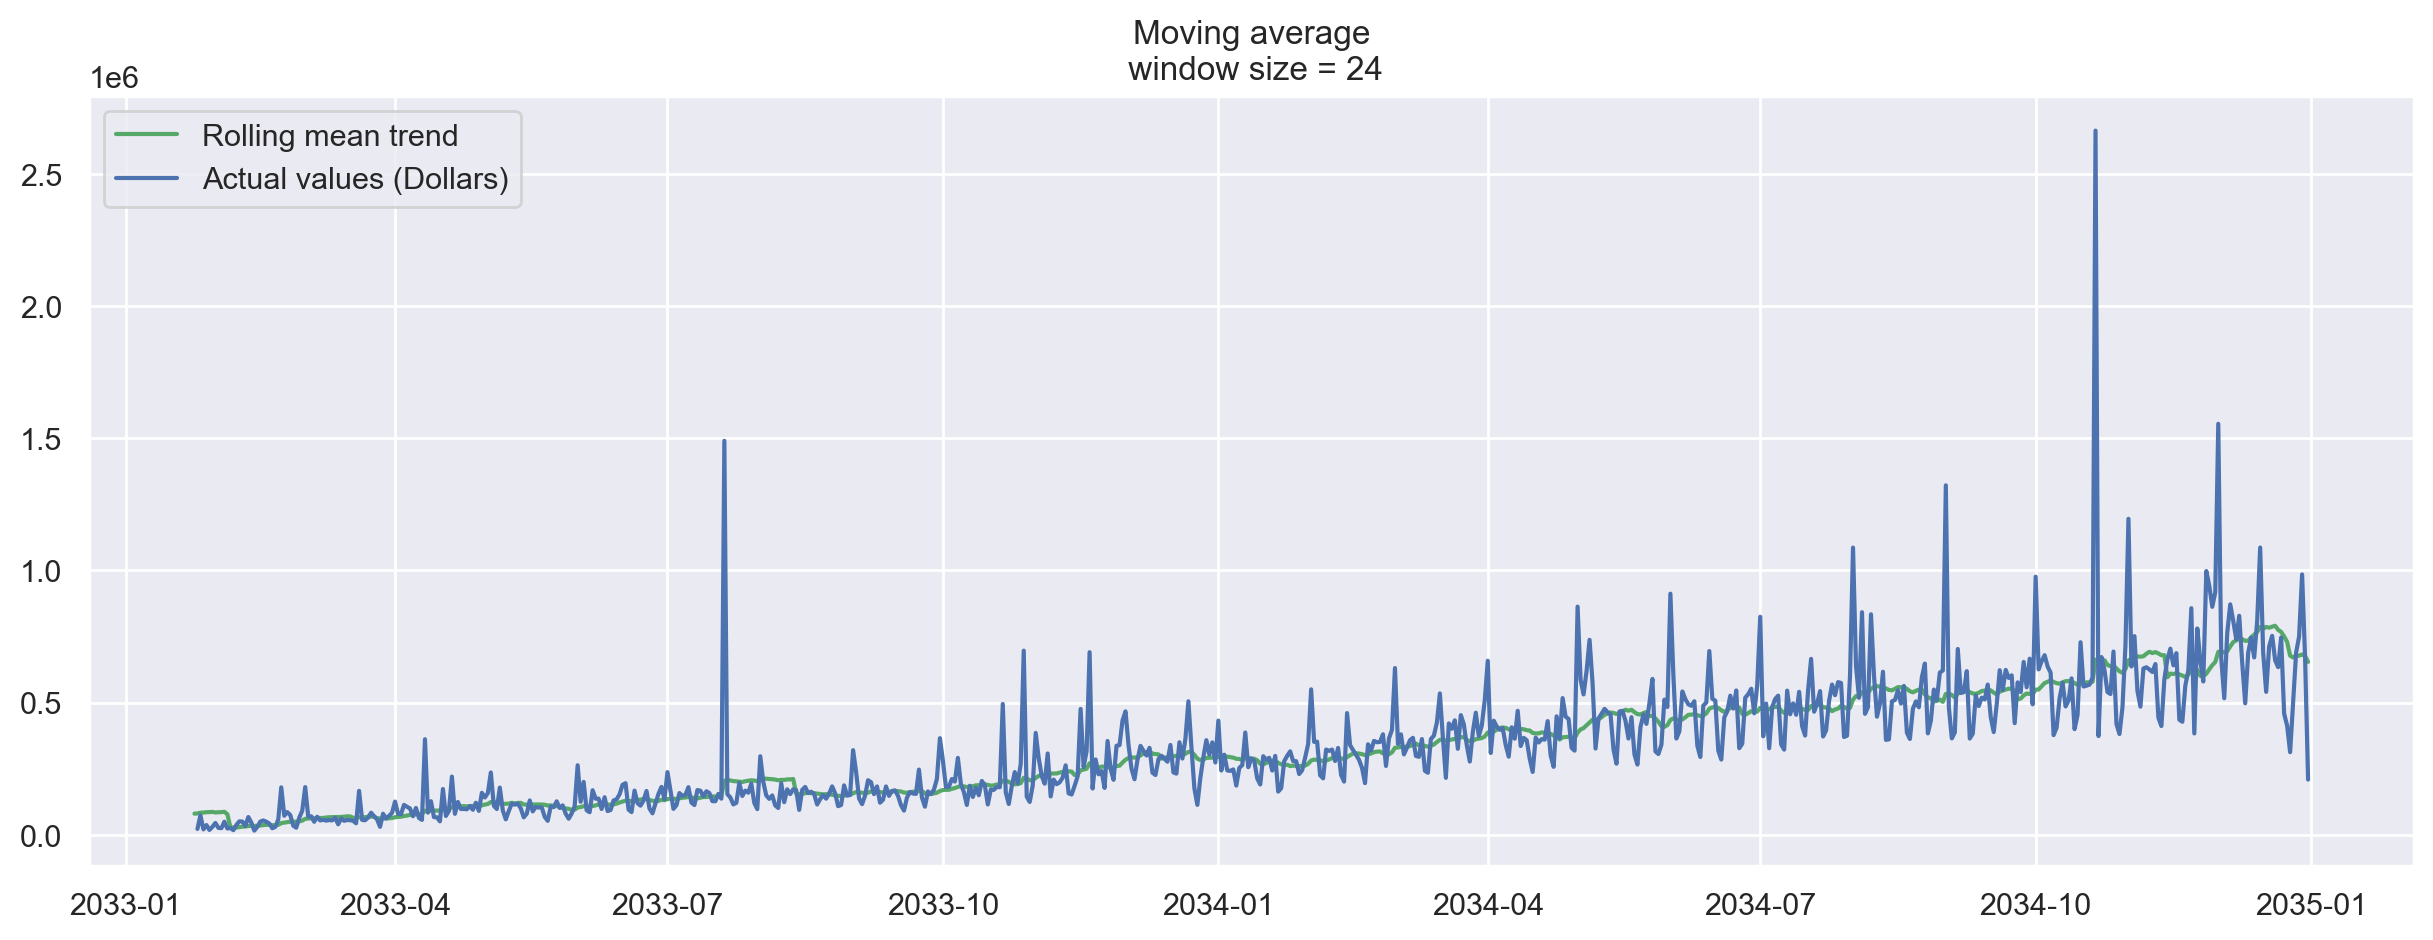

In [436]:
    Dollar_series = df.resample("D")["amount_usd_in_cents"].sum()/100 # Time Series in US Dollars
    plotMovingAverage(Dollar_series, 24)

In [437]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [439]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [438]:
%%time
data = Dollar_series[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()



0.008681677038578584 0.026753637233499827 0.09102128155093181
CPU times: total: 2.77 s
Wall time: 2.77 s


In [376]:
model.initial_seasonal_components()

{0: -29450.629597701136,
 1: -9831.733045977004,
 2: -27510.042356321836,
 3: -29563.939252873548,
 4: -11747.971666666659,
 5: 6966.334195402314,
 6: -5320.566839080447,
 7: -168.10718390803407,
 8: 51344.87385057472,
 9: -14909.127528735617,
 10: 92683.71454022989,
 11: 19770.95212643679,
 12: 36916.53626436784,
 13: -8748.350977011485,
 14: 60.9283333333462,
 15: -26334.068908045963,
 16: 2786.29729885059,
 17: -18636.24201149424,
 18: 3539.3128160919637,
 19: -22118.460632183895,
 20: 319.9466091954121,
 21: -3766.253045977001,
 22: -15467.241321839065,
 23: 9183.838333333357}

In [377]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    mse_rf = mean_squared_error(series.values, model.result[: len(series)])
    r2_rf = r2_score(series.values, model.result[: len(series)])
    print(f"Mean Squared Error (MSE): {mse_rf}")
    print(f"R-squared (R2): {r2_rf}")

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

Mean Squared Error (MSE): 20060832027.238697
R-squared (R2): 0.6717159537311732


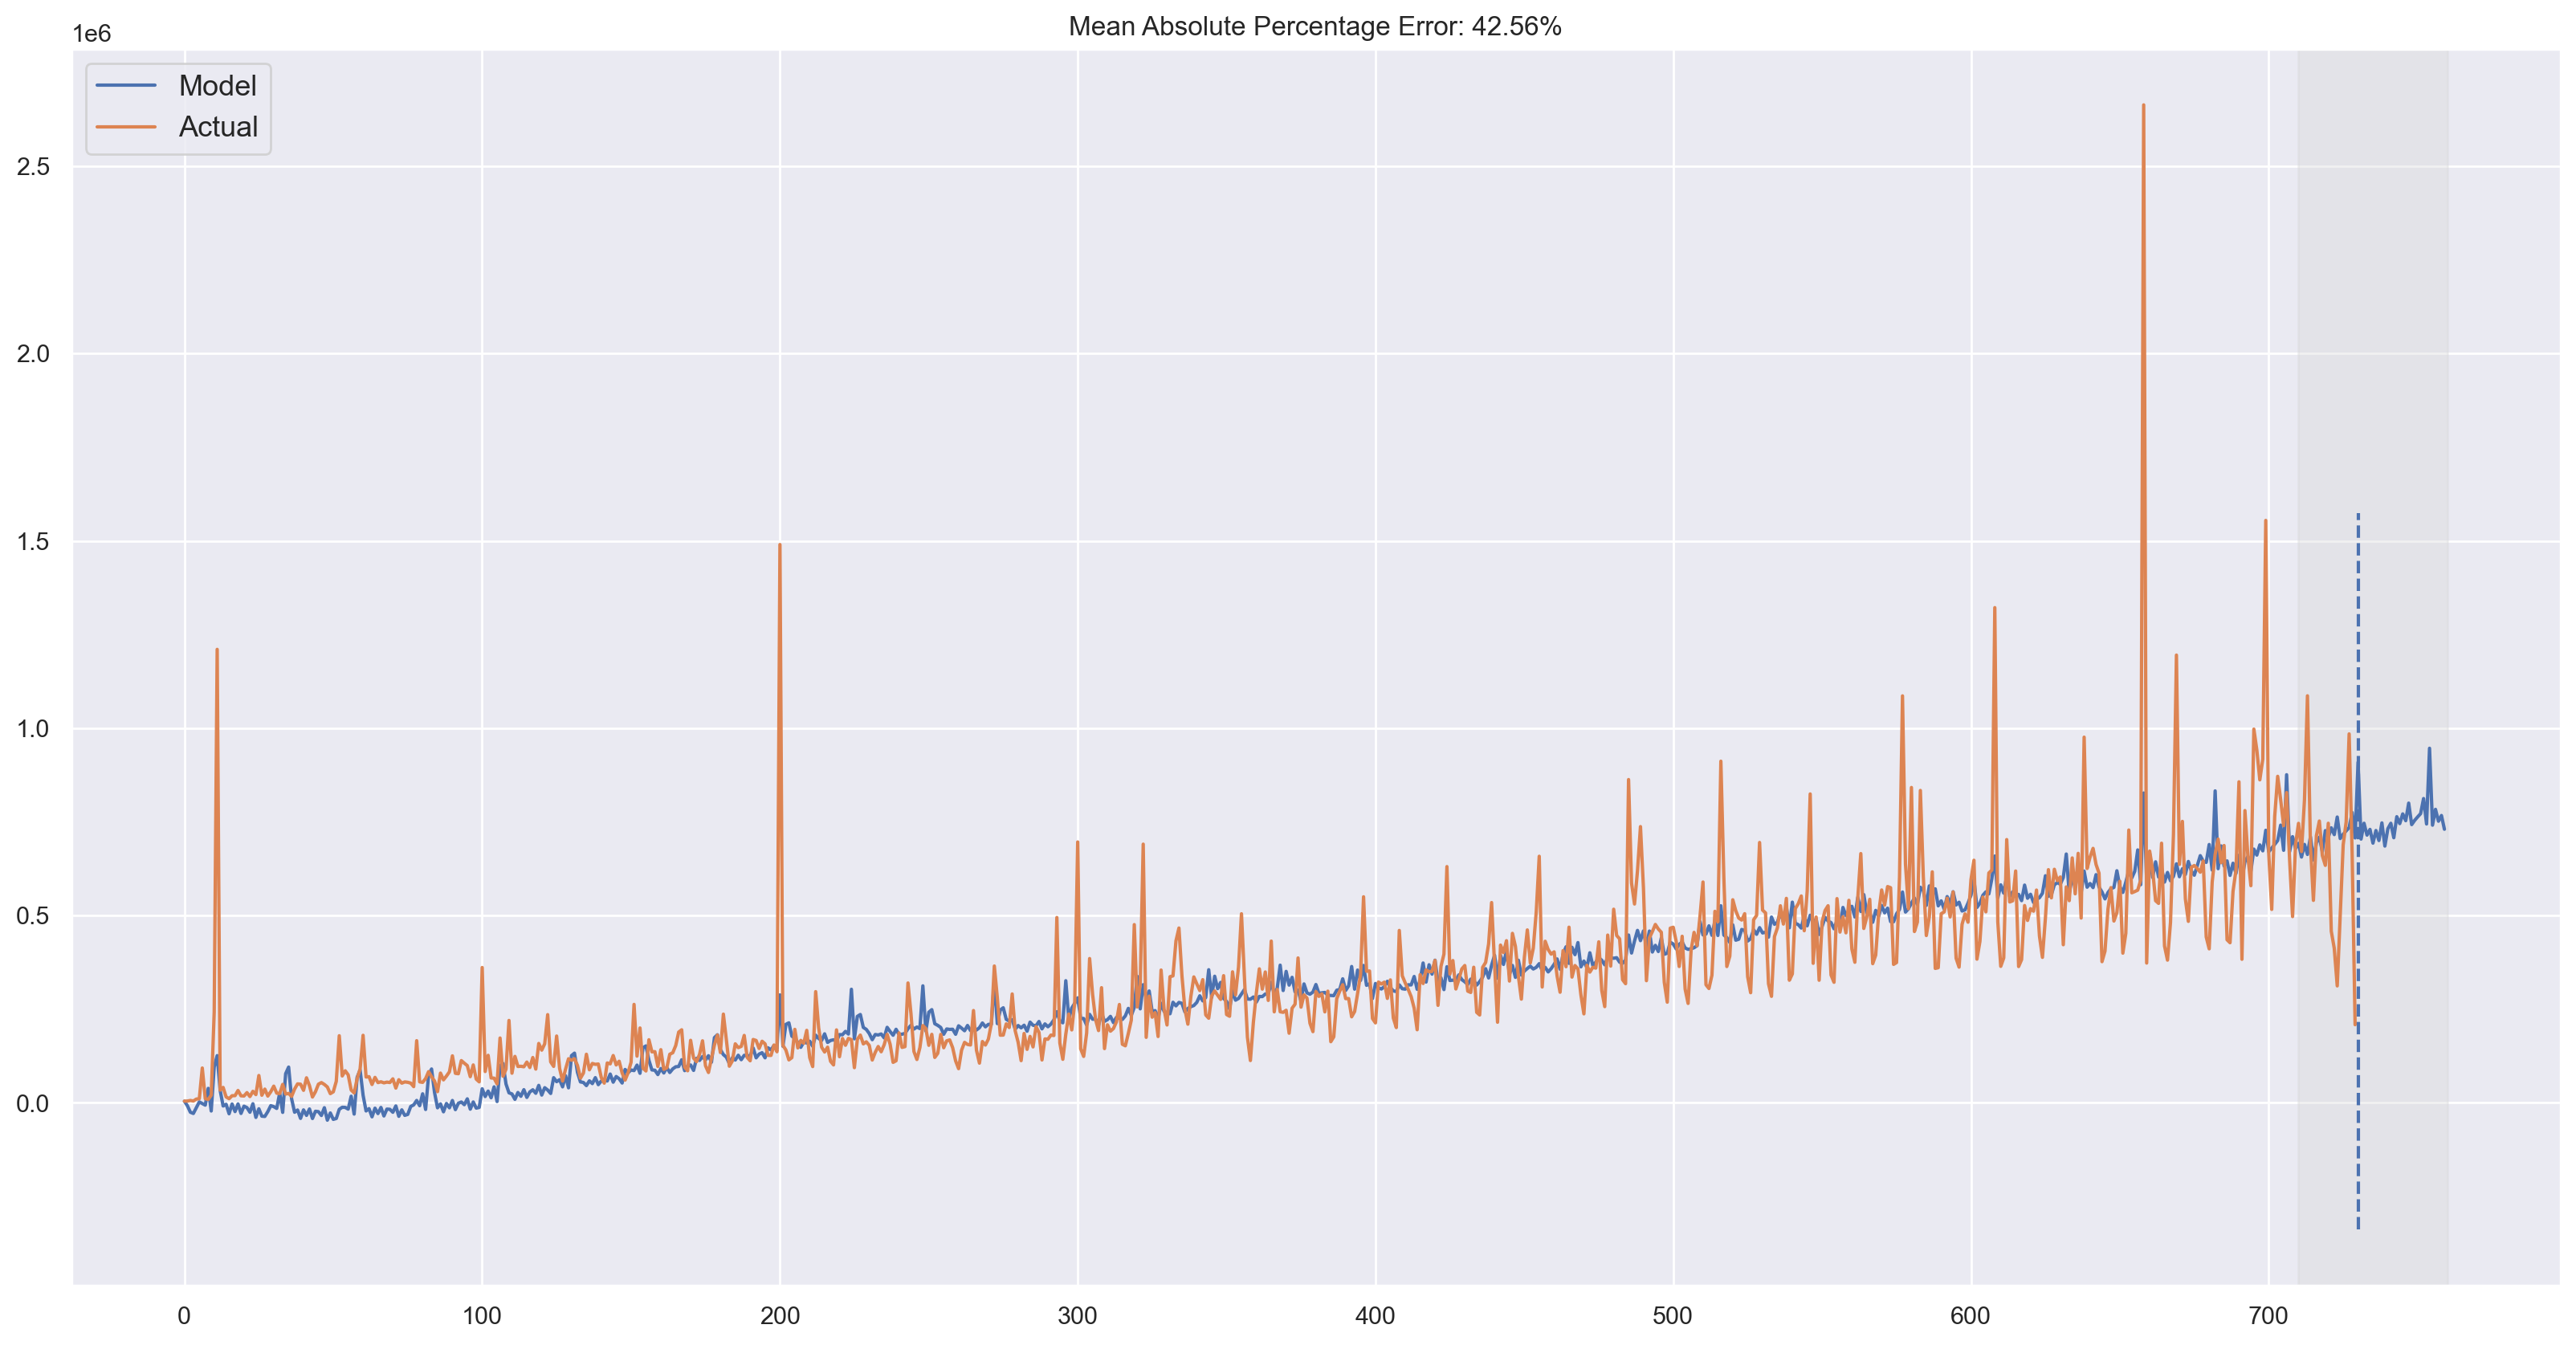

In [378]:
plotHoltWinters(Dollar_series) # HoltWinters' Model Plots

Mean Squared Error (MSE): 20060832027.238697
R-squared (R2): 0.6717159537311732


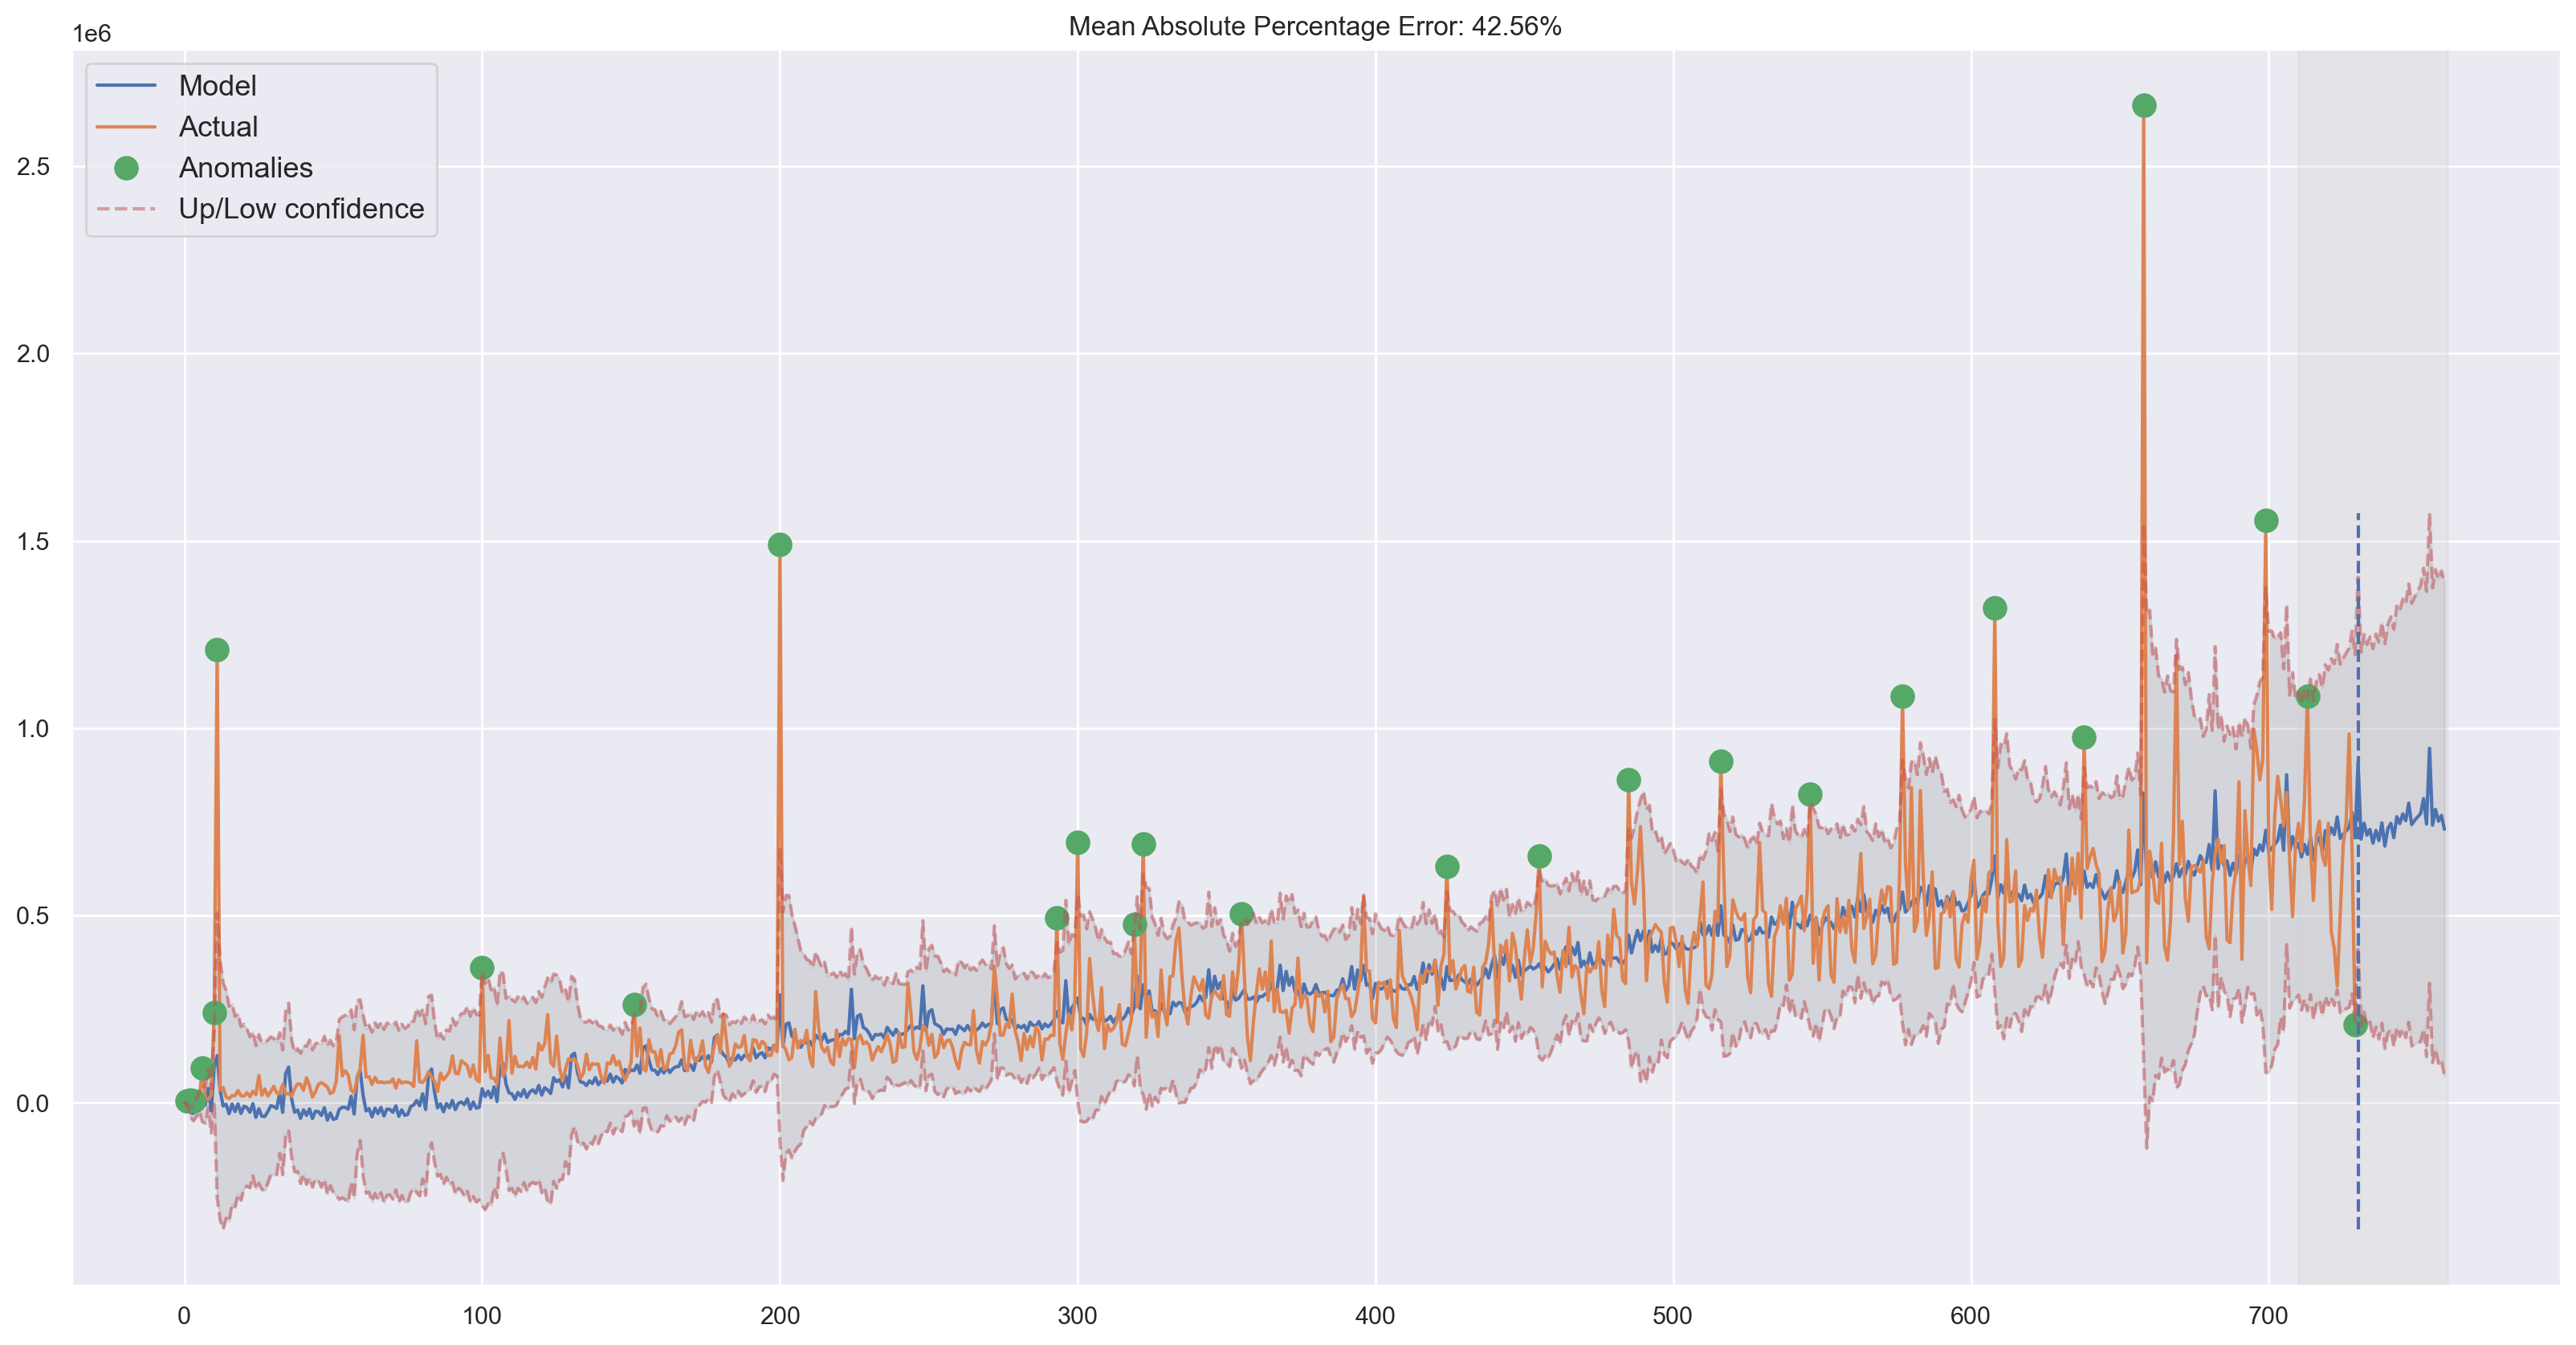

In [379]:
plotHoltWinters(Dollar_series, plot_intervals=True, plot_anomalies=True)

In [440]:
Dollar_series.head()

time
2033-01-01     4415.40
2033-01-02     4758.62
2033-01-03     6283.53
2033-01-04     4851.11
2033-01-05    10016.21
Freq: D, Name: amount_usd_in_cents, dtype: float64

In [441]:
# Time Series Lags
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(Dollar_series.copy())
data.columns = ["y"]

In [442]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [443]:
# take a look at the new dataframe
data.tail(5)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,,
2034-12-27,688573.47,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25,764173.63,516244.61
2034-12-28,750020.80,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25,764173.63
2034-12-29,984672.08,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25
2034-12-30,668559.95,412629.69,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37
2034-12-31,208533.08,312083.41,412629.69,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85


In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2033-01-01 to 2034-12-31
Freq: D
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       730 non-null    float64
 1   lag_6   724 non-null    float64
 2   lag_7   723 non-null    float64
 3   lag_8   722 non-null    float64
 4   lag_9   721 non-null    float64
 5   lag_10  720 non-null    float64
 6   lag_11  719 non-null    float64
 7   lag_12  718 non-null    float64
 8   lag_13  717 non-null    float64
 9   lag_14  716 non-null    float64
 10  lag_15  715 non-null    float64
 11  lag_16  714 non-null    float64
 12  lag_17  713 non-null    float64
 13  lag_18  712 non-null    float64
 14  lag_19  711 non-null    float64
 15  lag_20  710 non-null    float64
 16  lag_21  709 non-null    float64
 17  lag_22  708 non-null    float64
 18  lag_23  707 non-null    float64
 19  lag_24  706 non-null    float64
dtypes: float64(20)
memory usage: 119.8 KB


In [445]:
# Train New Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [446]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [447]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [448]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [449]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")
            
            
    
    error = mean_absolute_percentage_error(prediction, y_test)
    print('MAPE = ', error)
    mse_rf = mean_squared_error(y_test,prediction)
    r2_rf = r2_score(y_test,prediction)
    print("mse_rf",mse_rf)
    print(f"Mean Squared Error (MSE): {mse_rf}")
    print(f"R-squared (R2): {r2_rf}")
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

MAPE =  20.939886824567626
mse_rf 50636512781.40211
Mean Squared Error (MSE): 50636512781.40211
R-squared (R2): 0.034761014156792


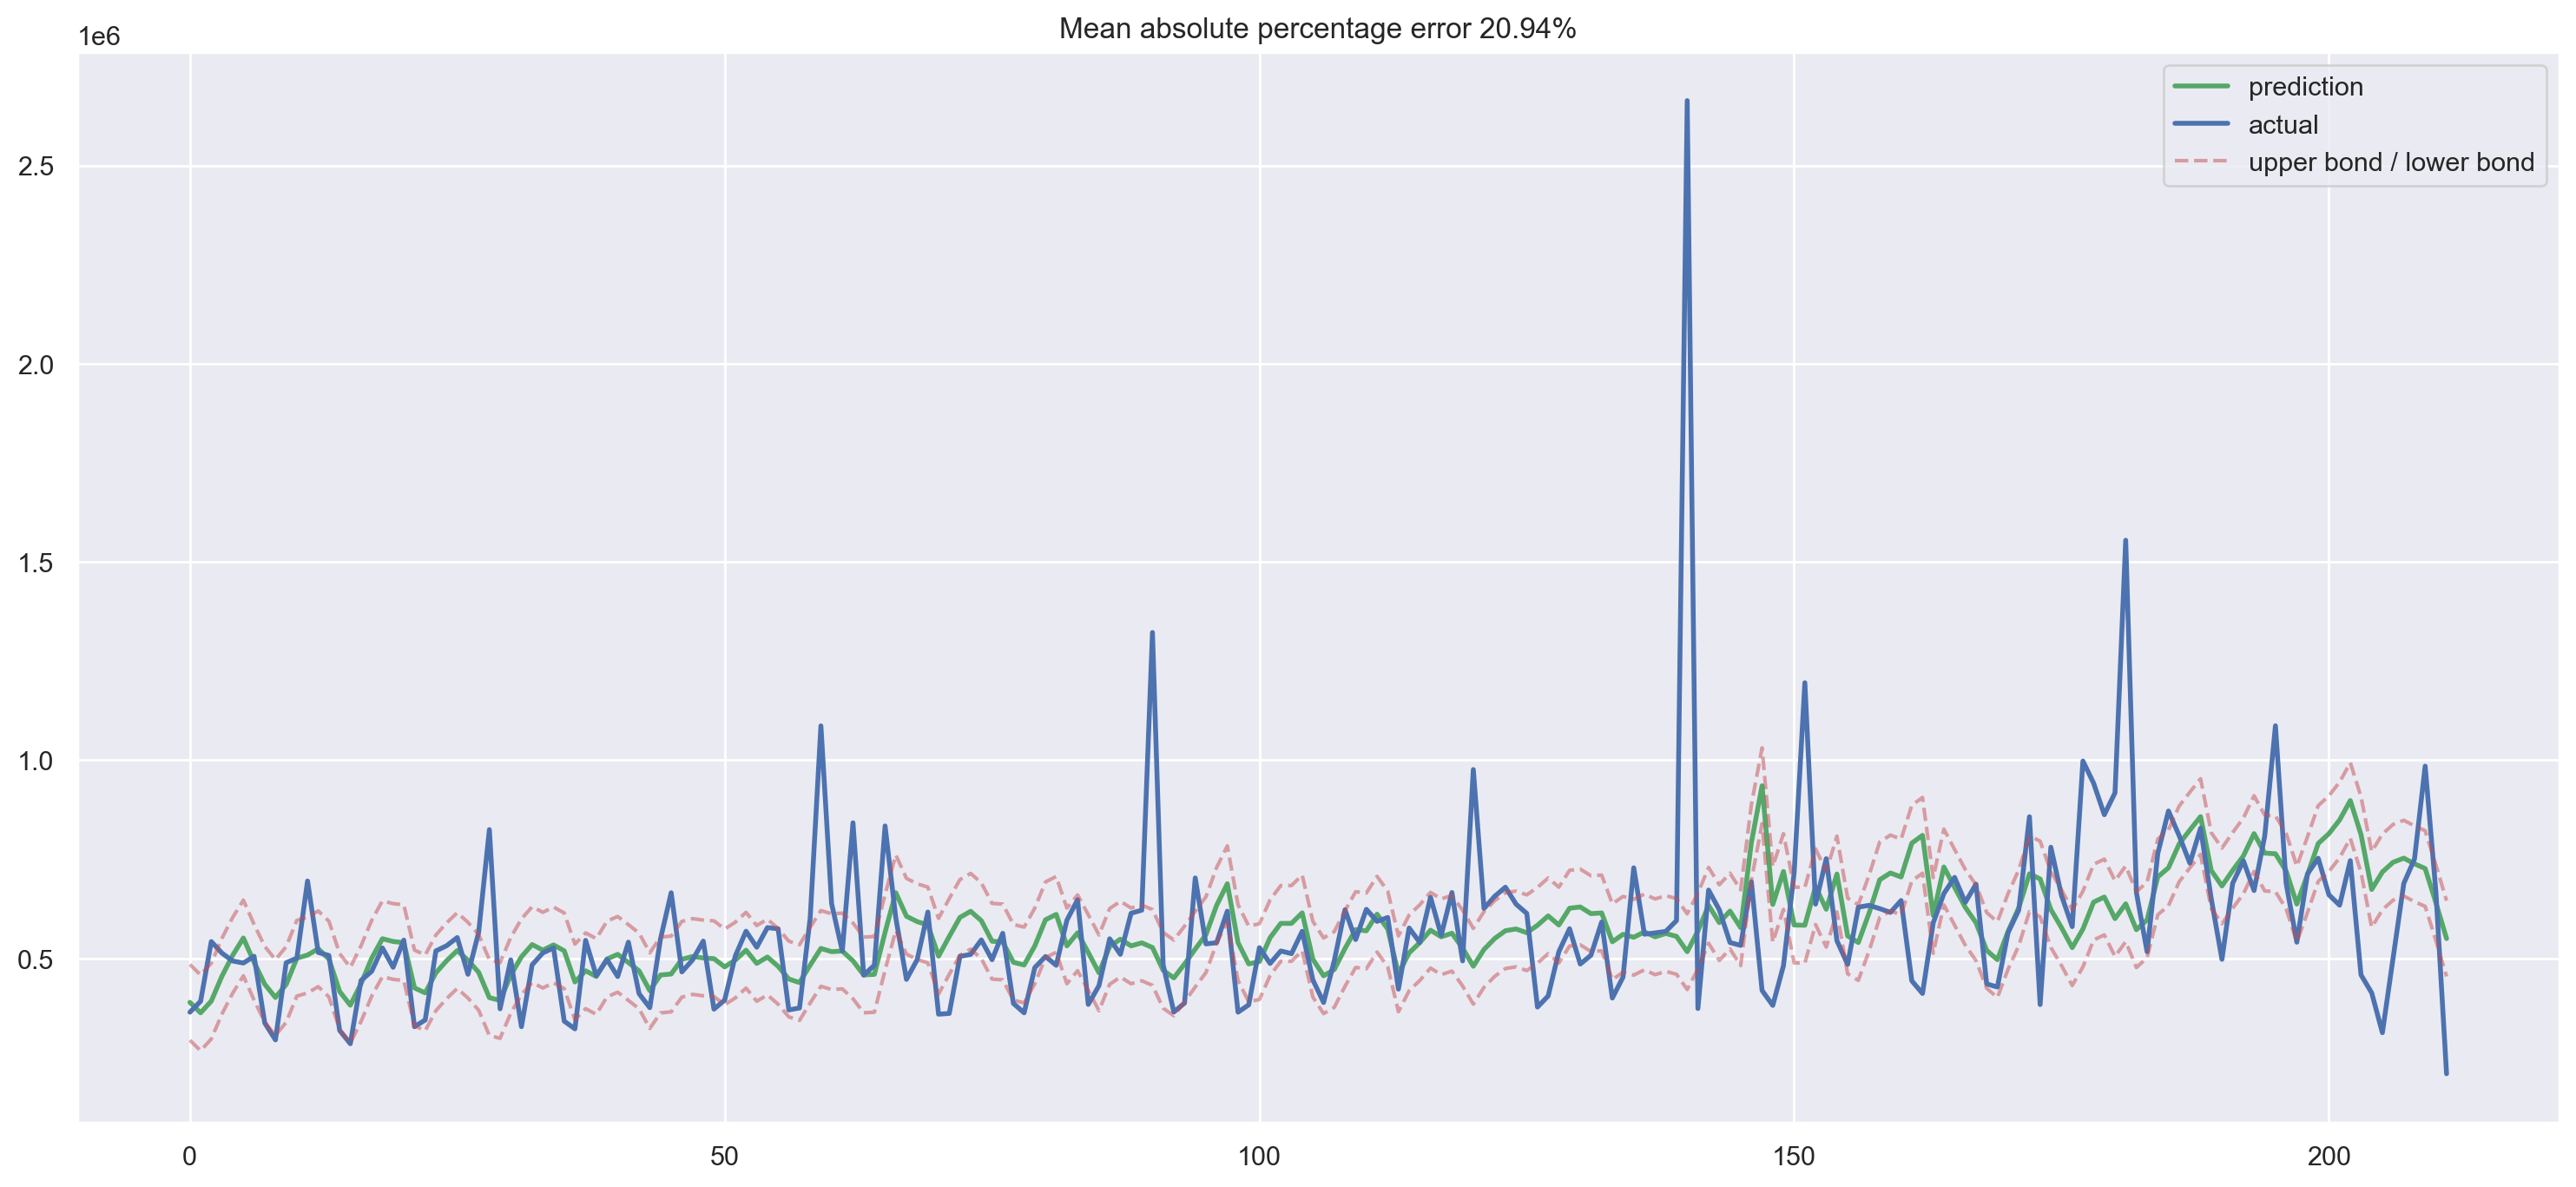

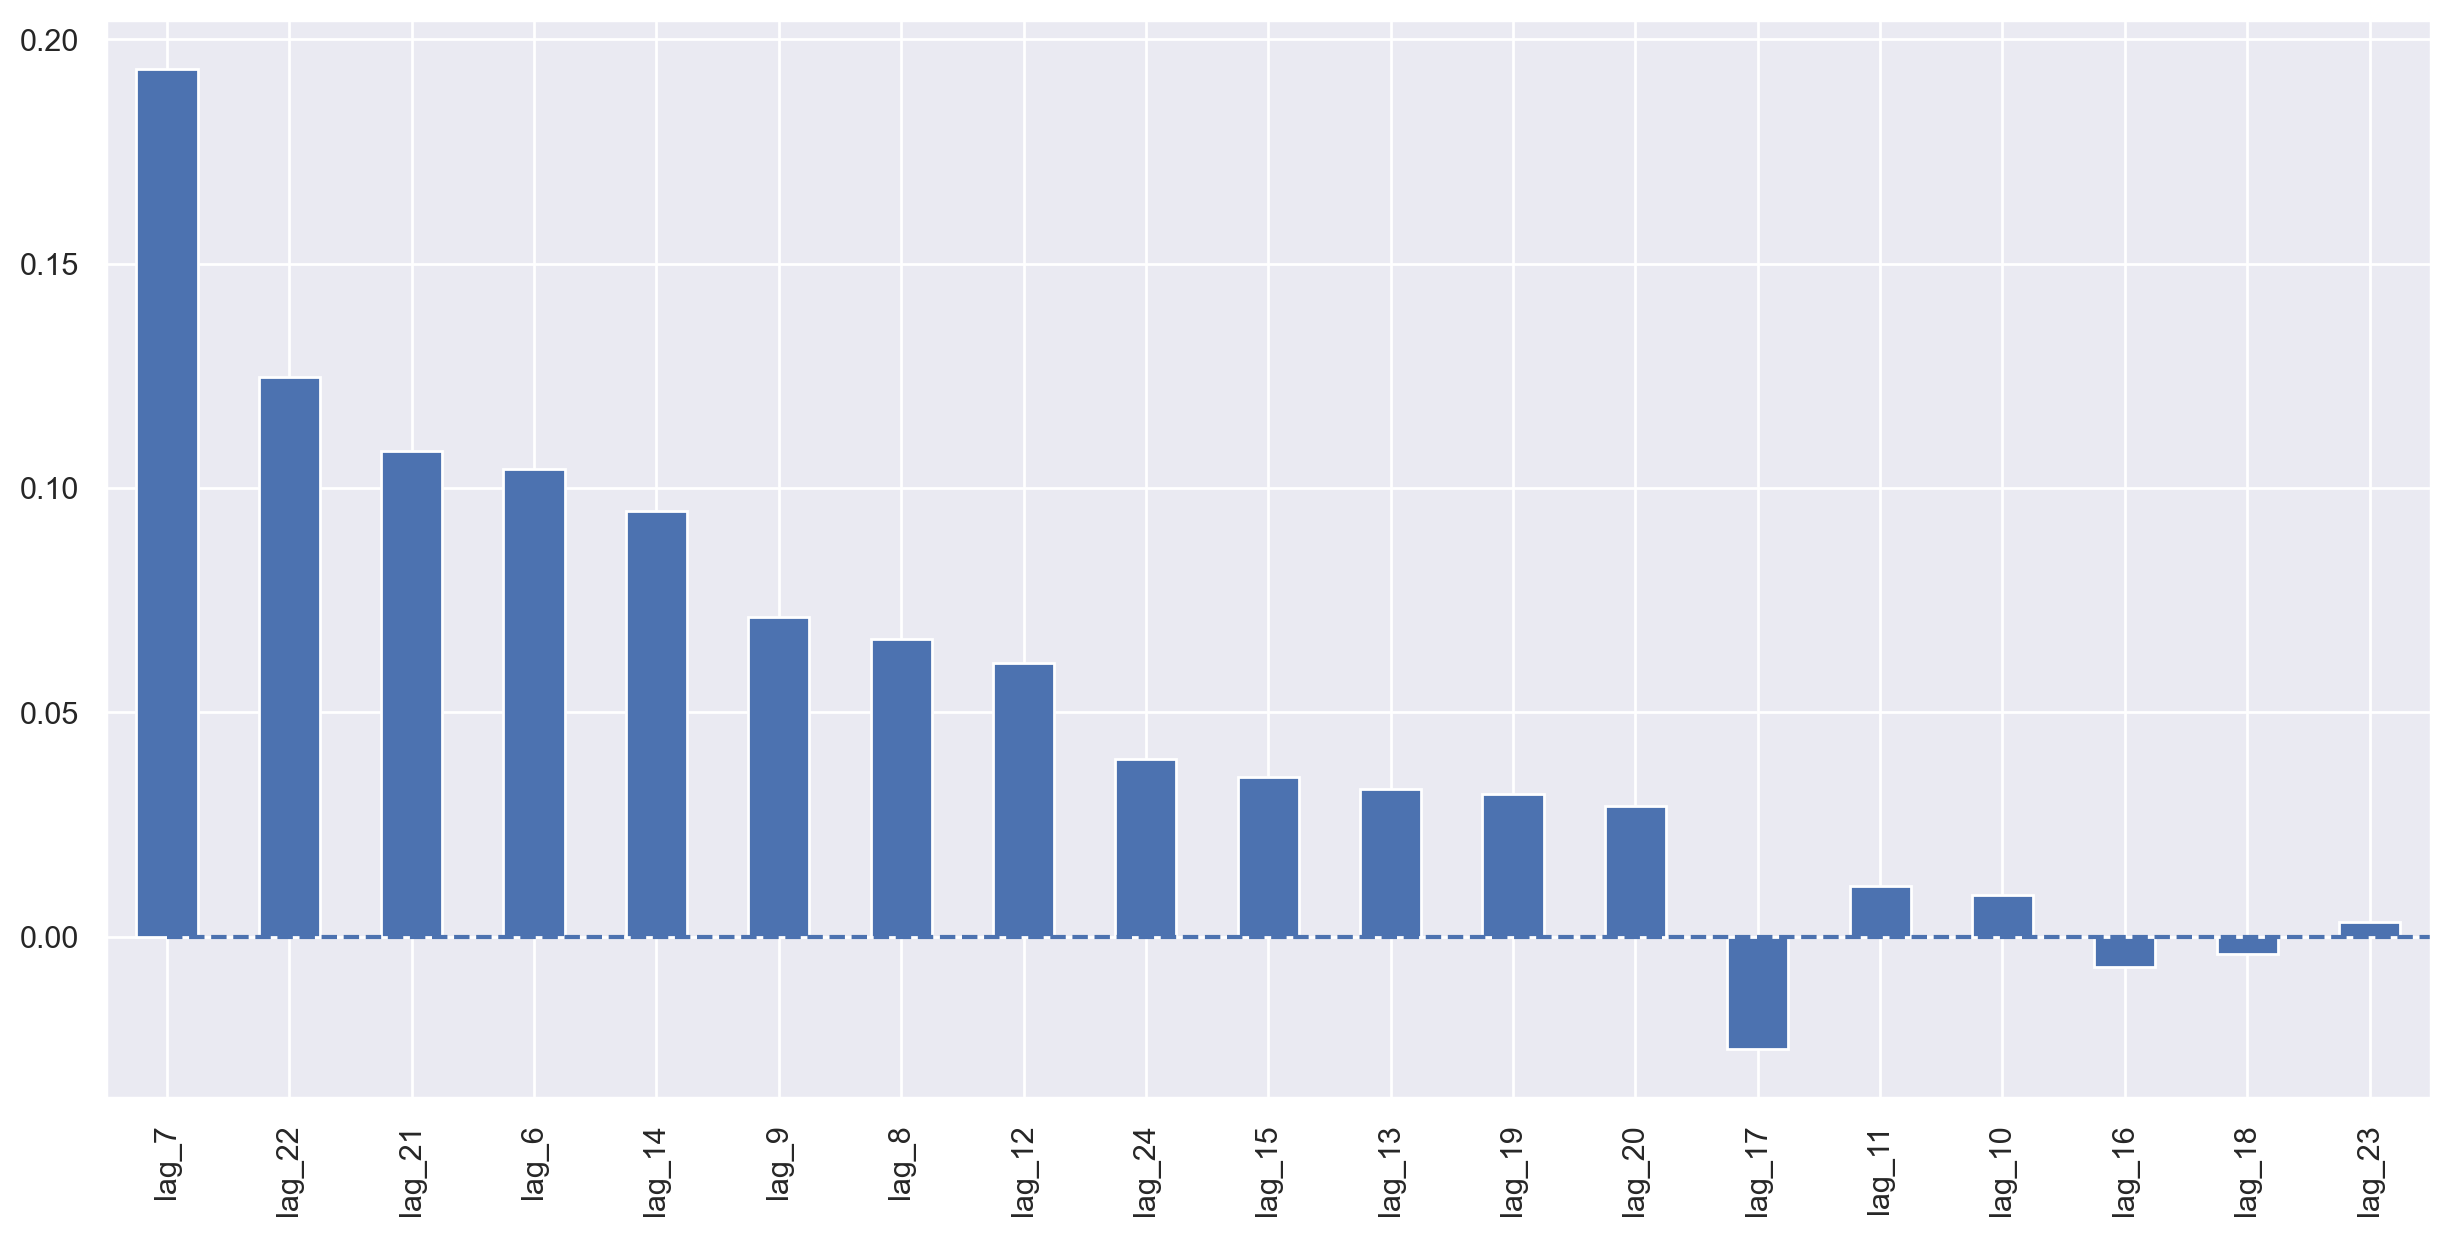

In [450]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [412]:
# Scale Feature Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [451]:
data.tail(5)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,,
2034-12-27,688573.47,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25,764173.63,516244.61
2034-12-28,750020.80,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25,764173.63
2034-12-29,984672.08,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37,871449.25
2034-12-30,668559.95,412629.69,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85,809039.37
2034-12-31,208533.08,312083.41,412629.69,457942.73,746183.26,633820.61,659891.45,752171.23,712842.49,540359.50,688965.40,1086375.85,808416.72,670715.73,745896.88,688829.95,497127.73,649725.58,828092.79,739696.85


MAPE =  20.939886824567626
mse_rf 50636512781.402084
Mean Squared Error (MSE): 50636512781.402084
R-squared (R2): 0.034761014156792336


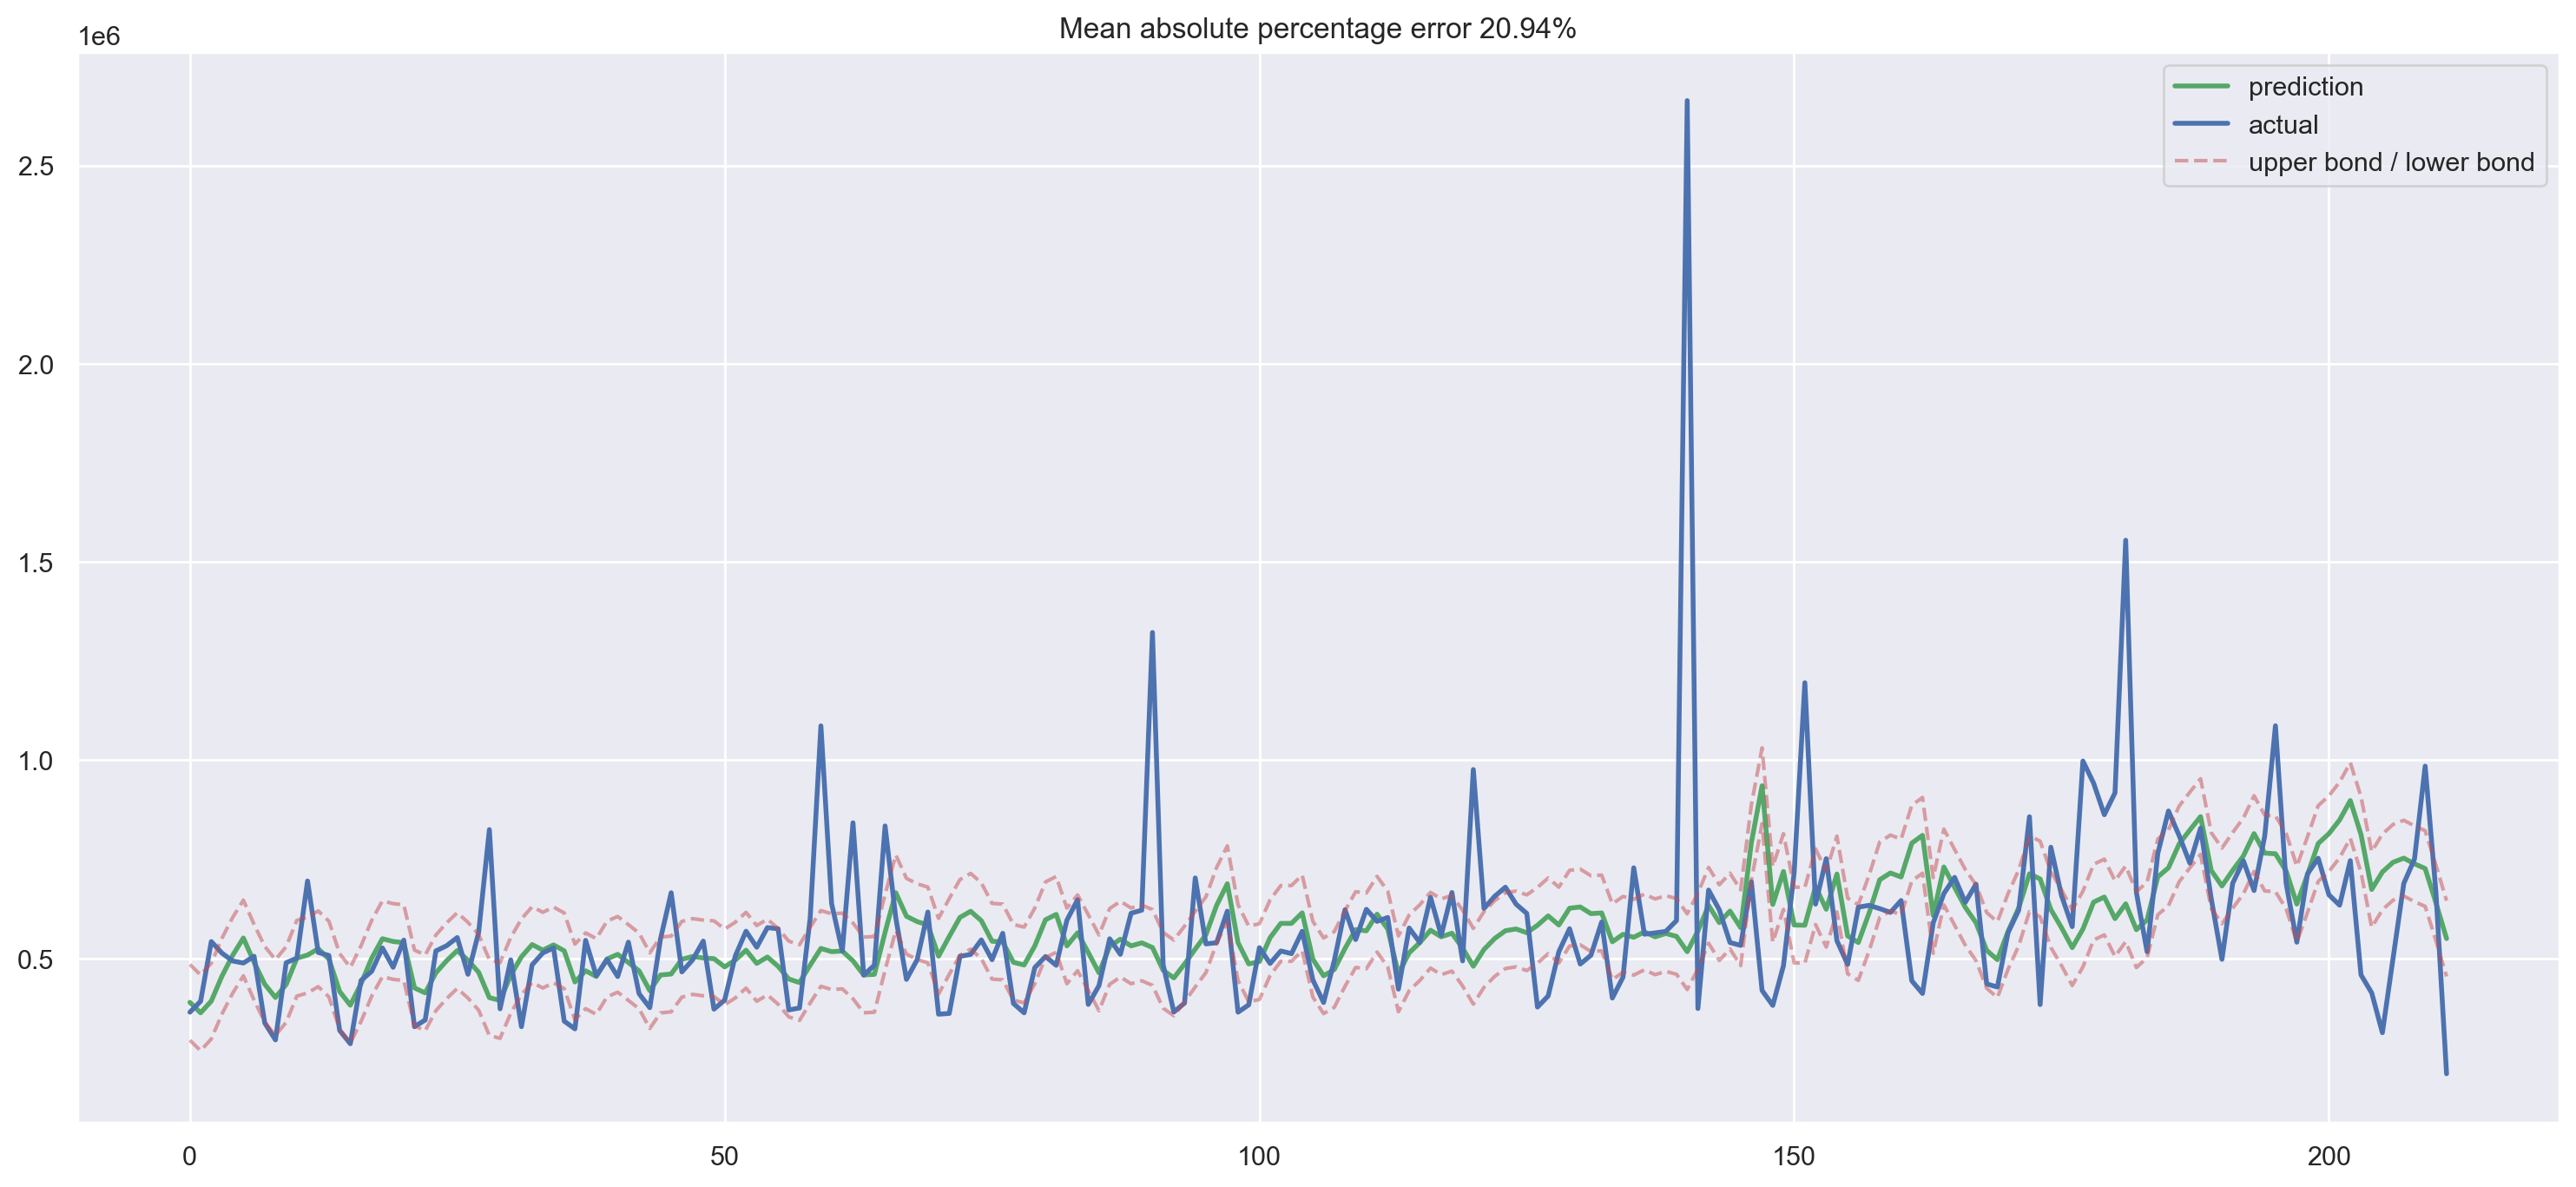

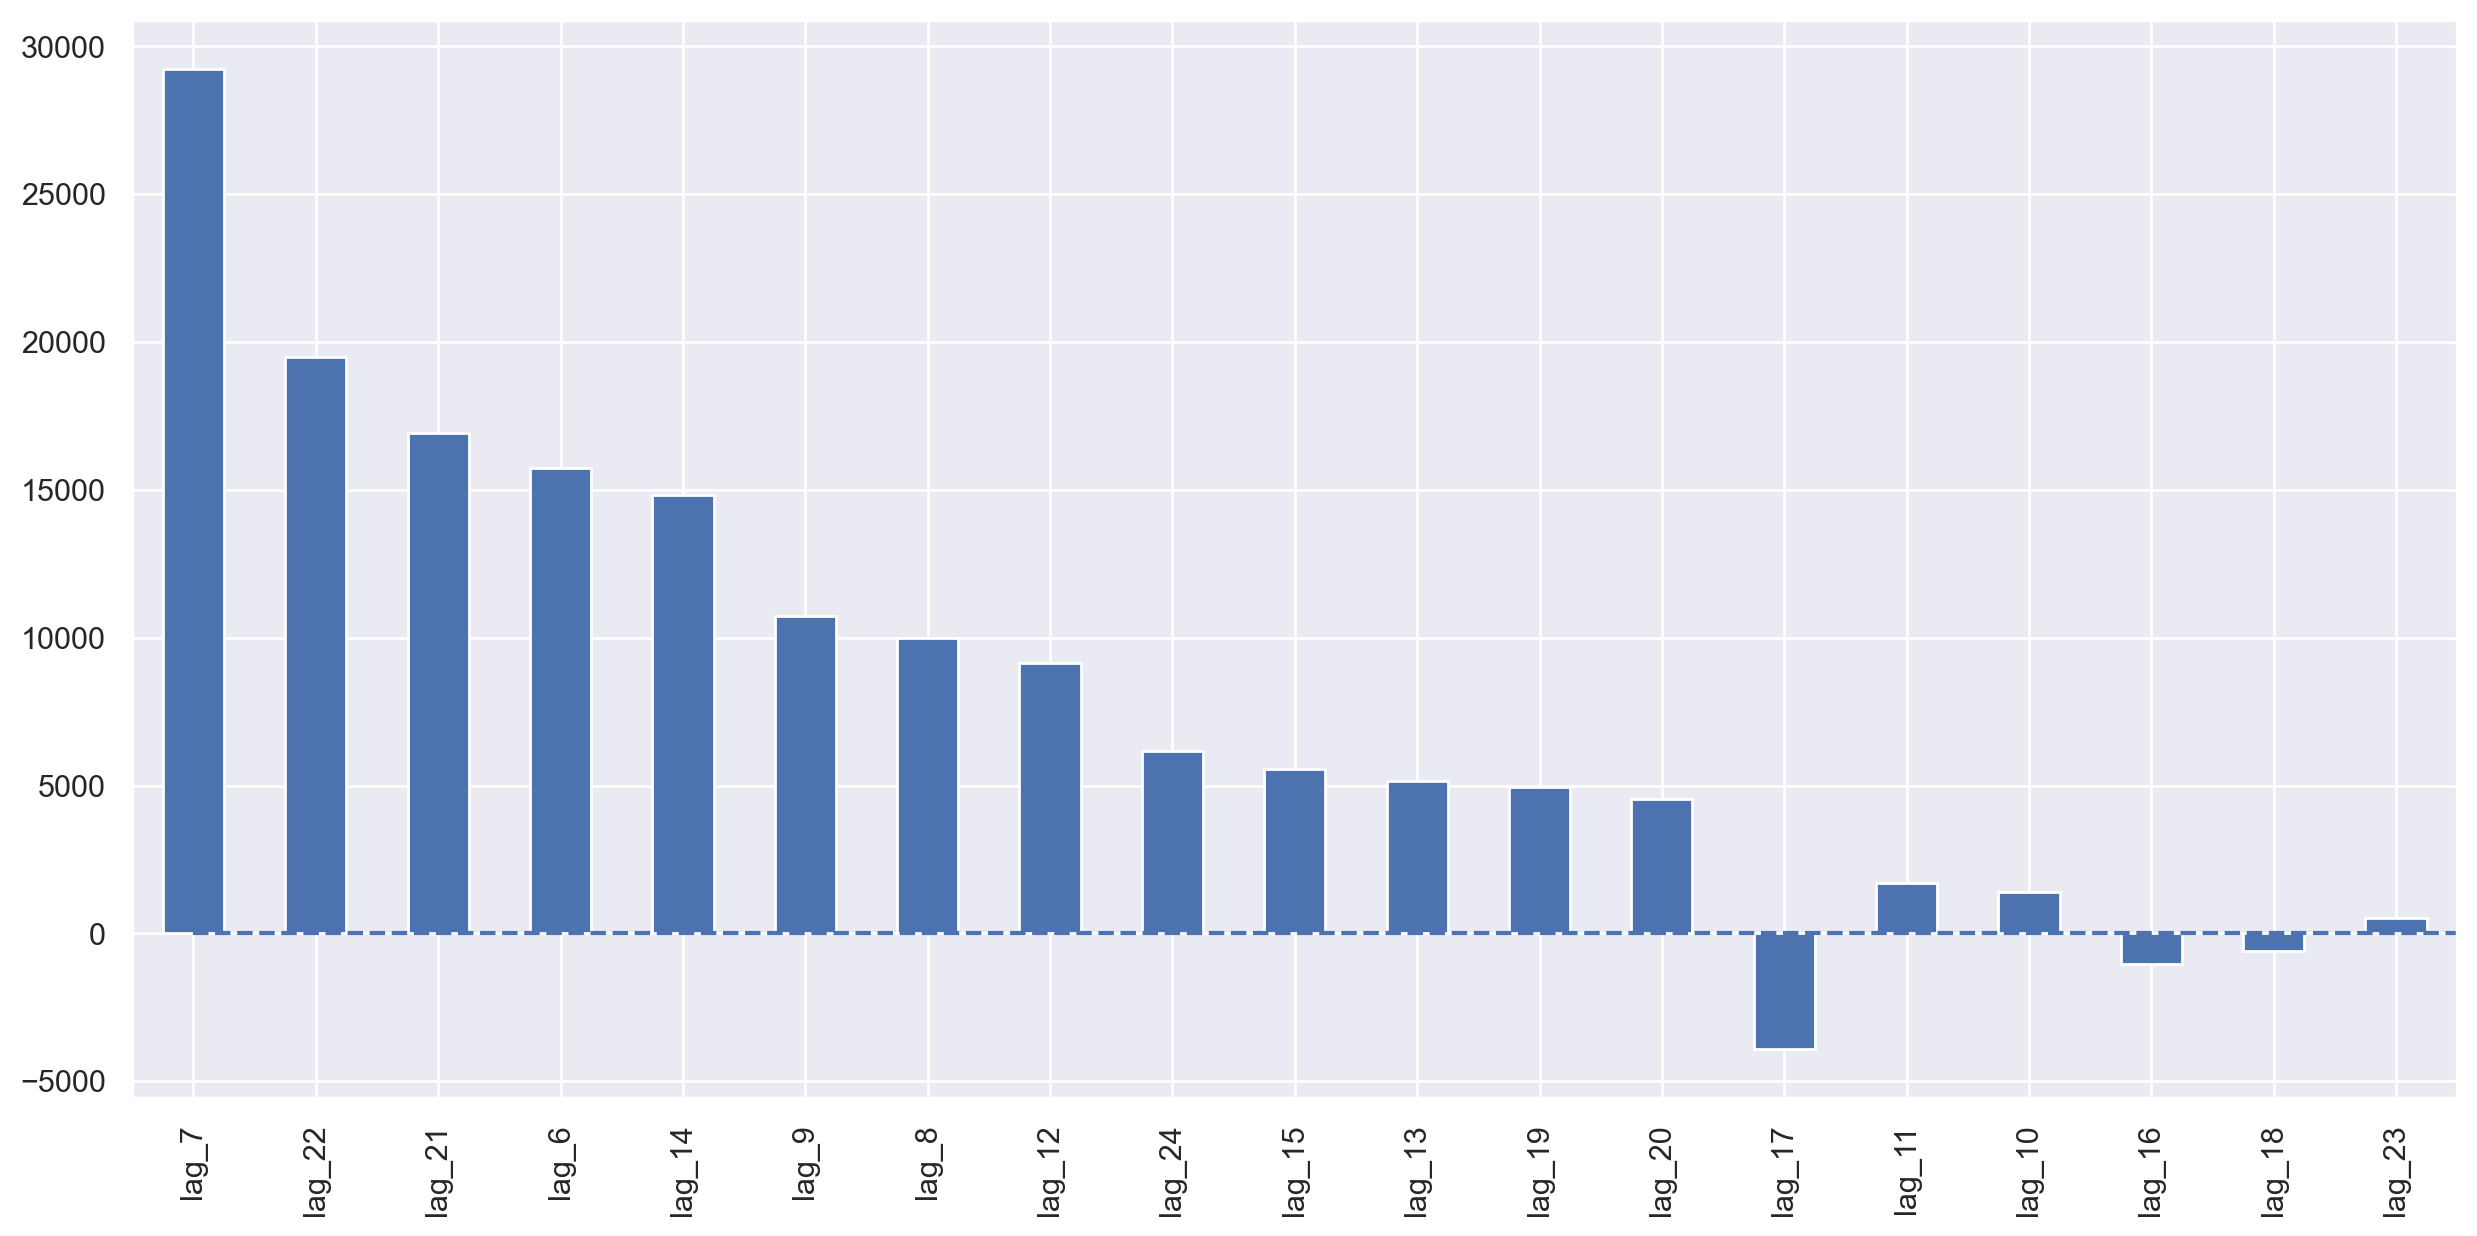

In [452]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [453]:
#Target Encoding
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [454]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """

    # copy of the initial dataset
    data = pd.DataFrame(Dollar_series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data["weekday_average"] = list(
            map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
        )
        data["hour_average"] = list(
            map(code_mean(data[:test_index], "hour", "y").get, data.hour)
        )

        # drop encoded variables
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size
    )

    return X_train, X_test, y_train, y_test

MAPE =  20.0473328863316
mse_rf 48693985629.86984
Mean Squared Error (MSE): 48693985629.86984
R-squared (R2): 0.07178968842218403


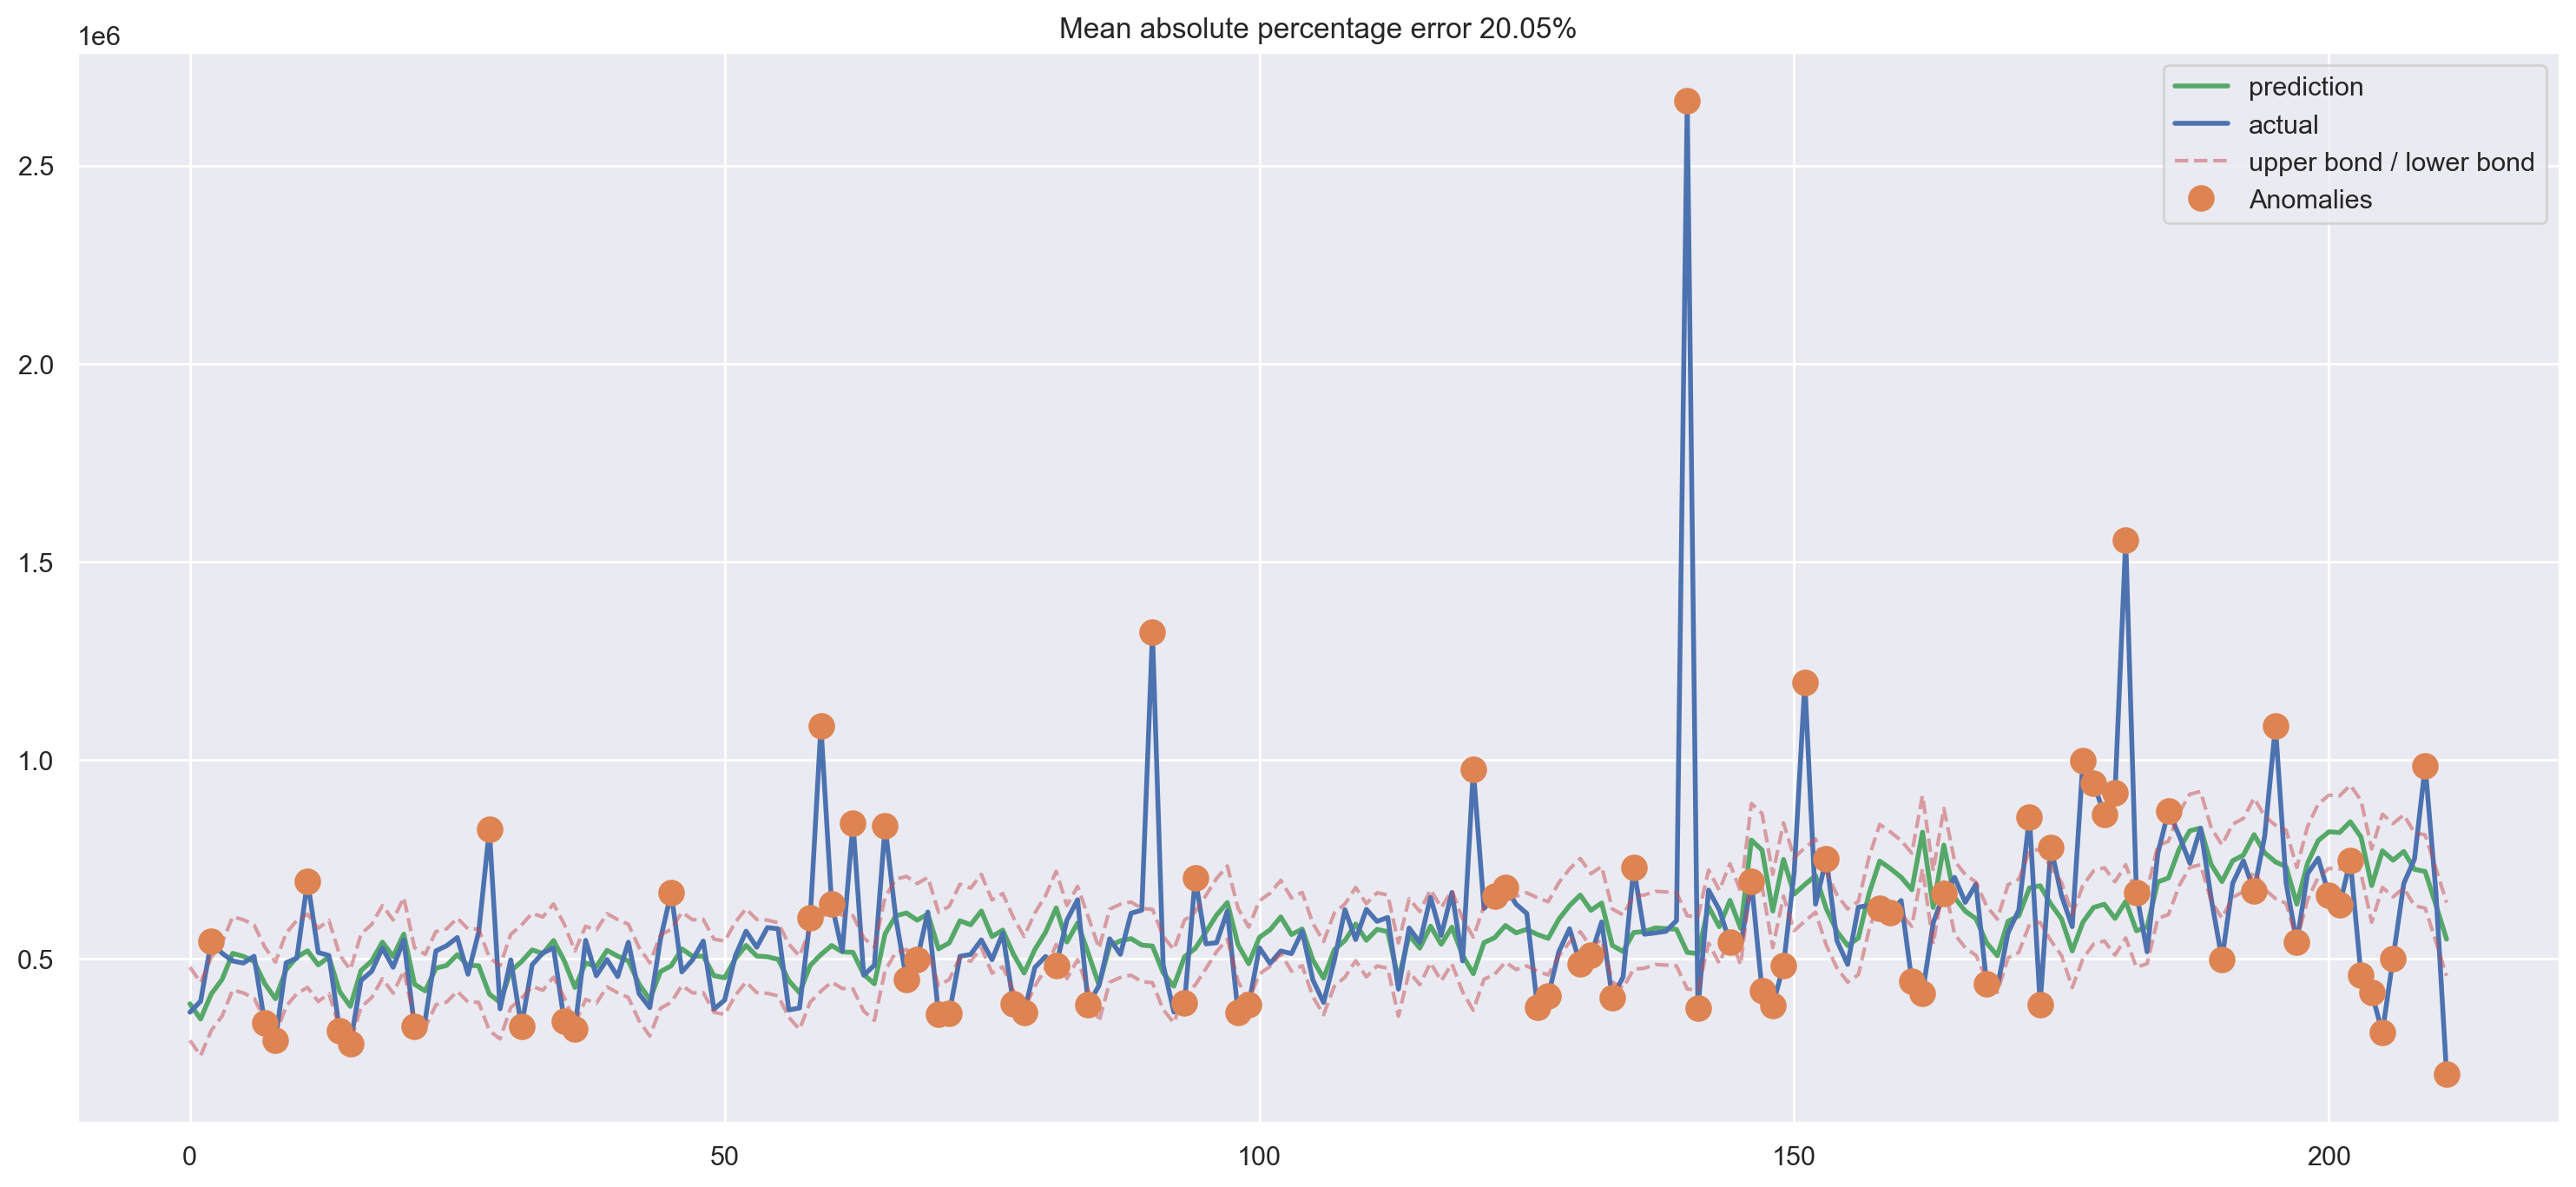

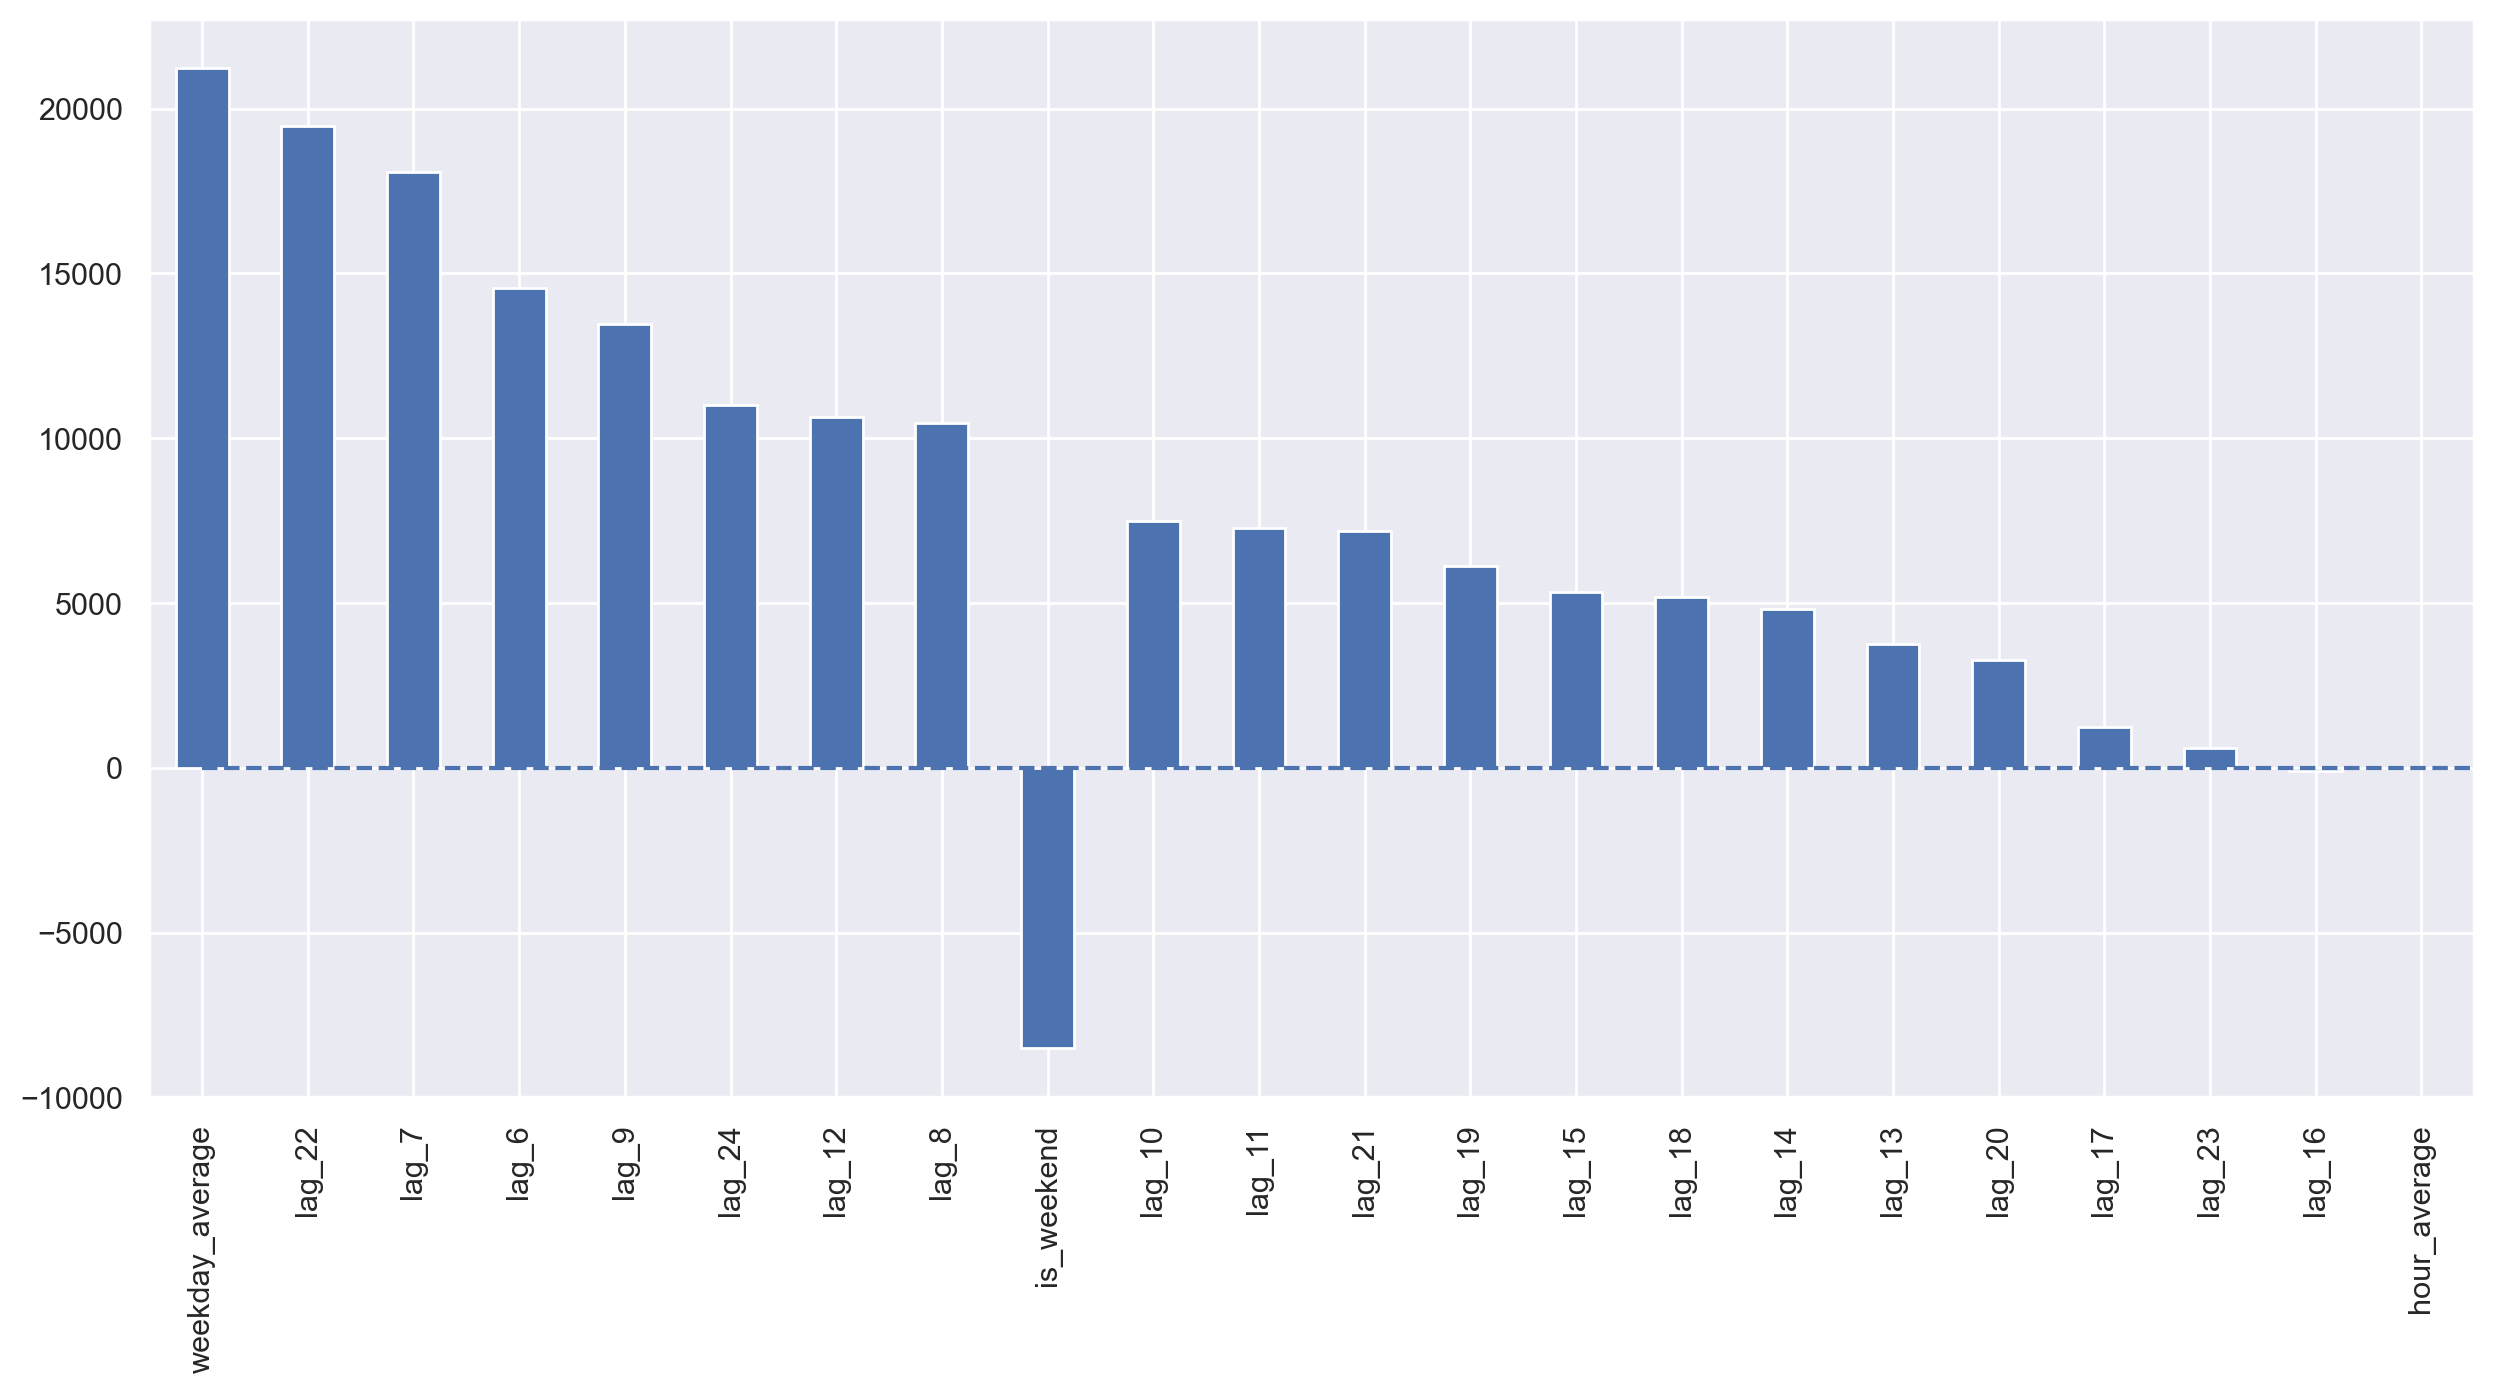

In [456]:
X_train, X_test, y_train, y_test = prepareData(
    Dollar_series, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(
    lr,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lr)

Mean Squared Error (MSE): 15263705886.011007
R-squared (R2): 0.7217034538781948


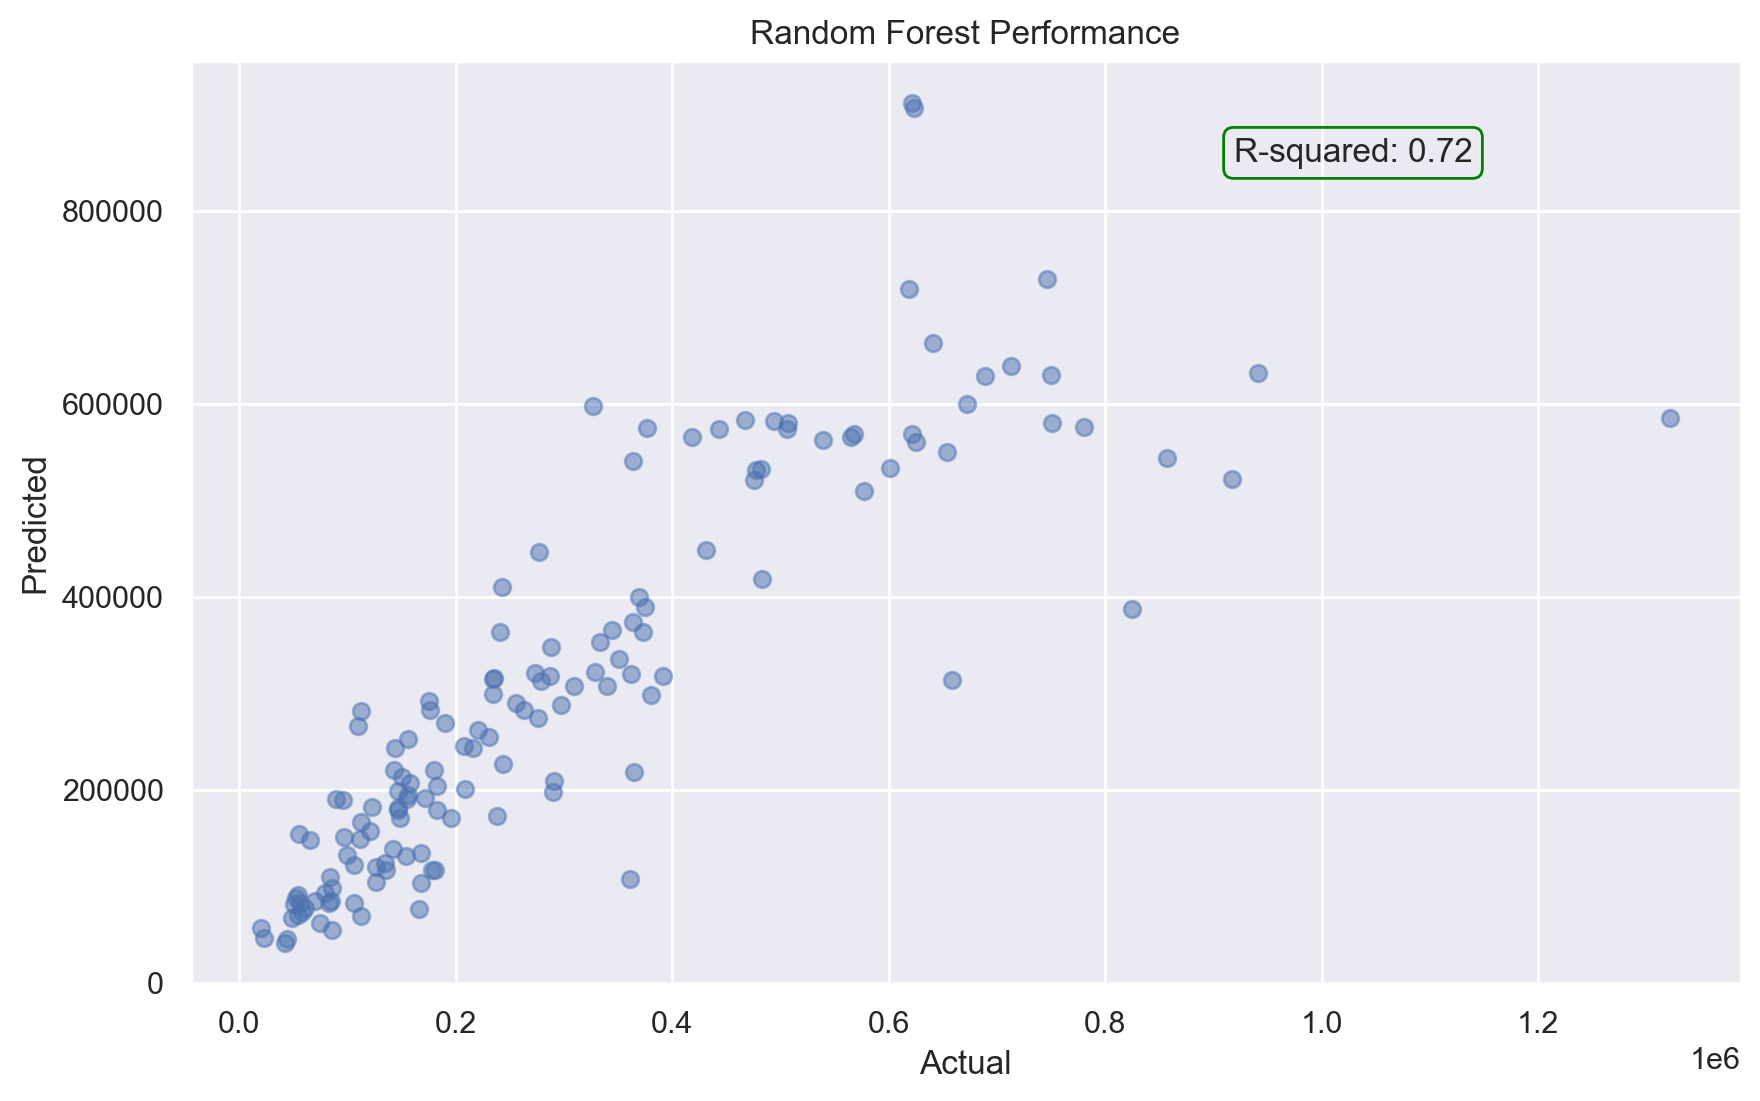

In [423]:
from sklearn.ensemble import RandomForestRegressor
# Keeping the selected features as before
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# Create and fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

#Evaluate performance using nd appropriate metric
from sklearn.metrics import mean_squared_error,r2_score

mse_rf = mean_squared_error(y_test,y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5,label="Data")

# Add the R-squared value as text
r2_test = f"R-squared: {r2_rf:.2f}"
plt.text(0.75, 0.9, r2_test, ha="center",va="center", transform=plt.gca().transAxes, bbox=dict(boxstyle="round",facecolor='none', edgecolor='green'))

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Performance")
plt.show()

Mean Squared Error (MSE): 16510493262.51361
R-squared (R2): 0.6989713190205034


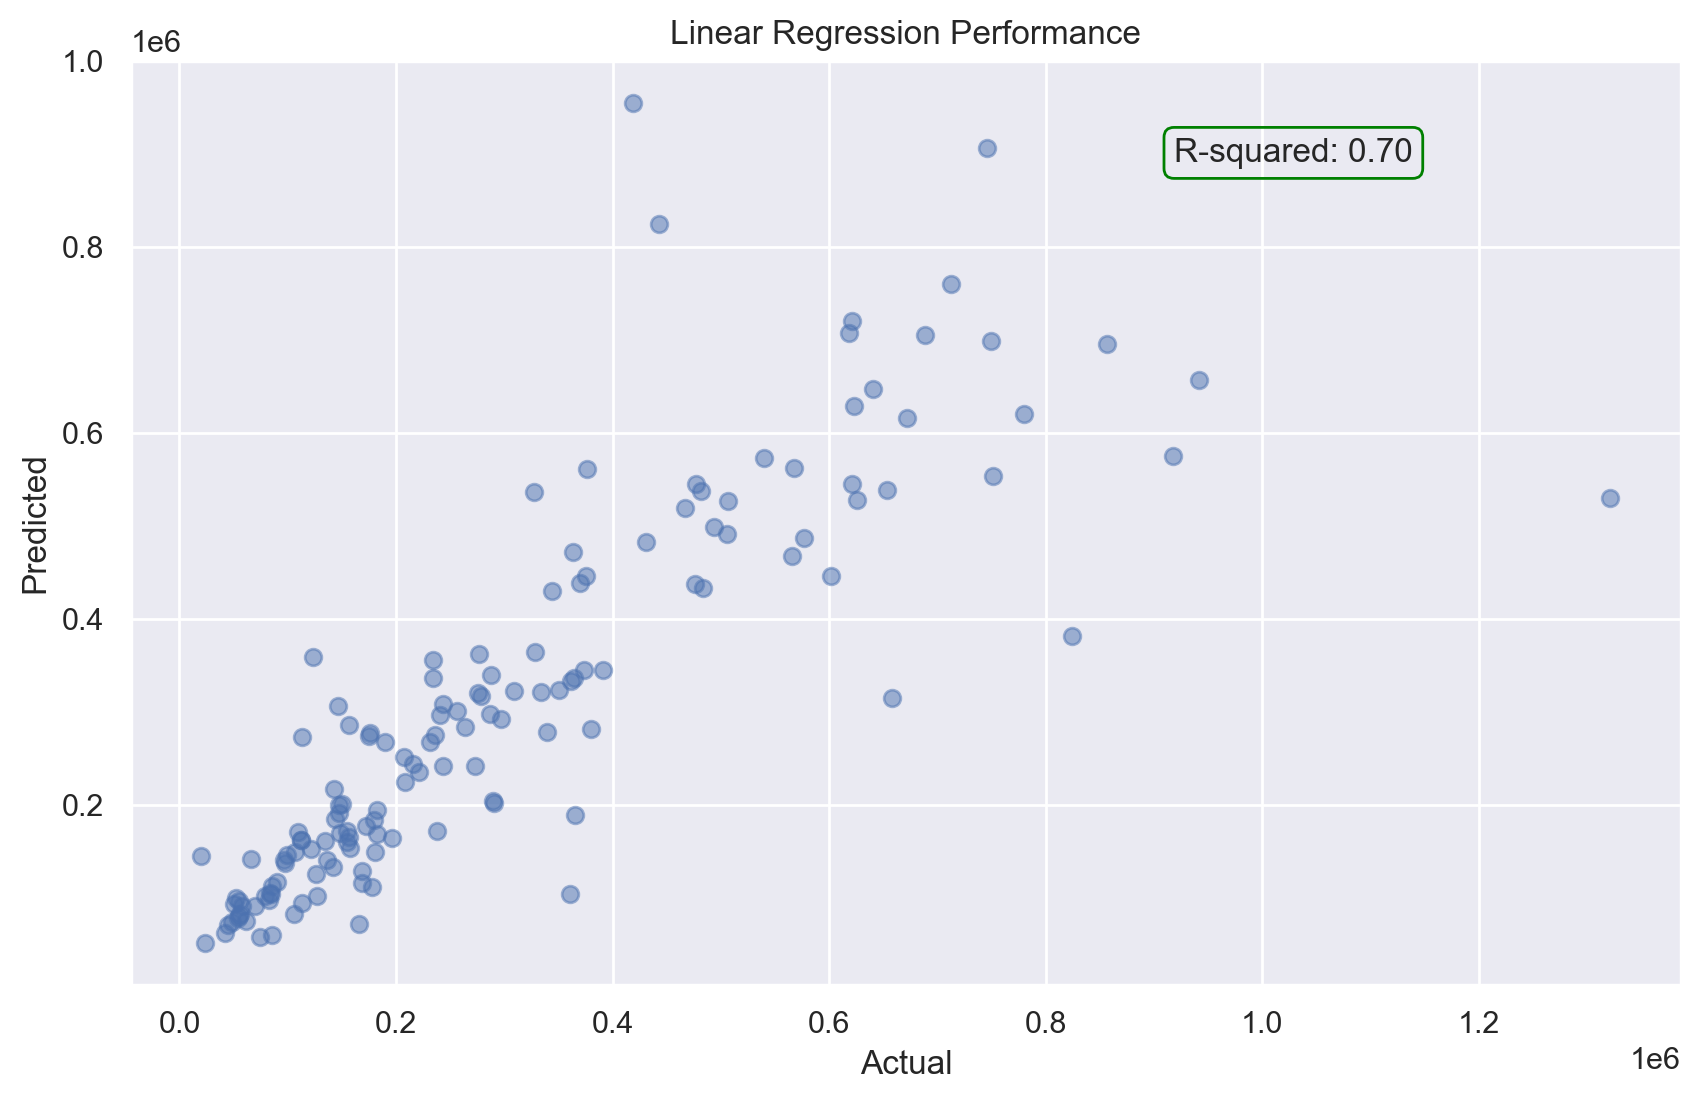

In [429]:
from sklearn.ensemble import RandomForestRegressor
# Keeping the selected features as before
# Spli data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# Create and fit the random forest model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

#Evaluate performance using nd appropriate metric
from sklearn.metrics import mean_squared_error,r2_score

mse_lr = mean_squared_error(y_test,y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"R-squared (R2): {r2_lr}")

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5,label="Data")

# Add the R-squared value as text
r2_test = f"R-squared: {r2_lr:.2f}"
plt.text(0.75, 0.9, r2_test, ha="center",va="center", transform=plt.gca().transAxes, bbox=dict(boxstyle="round",facecolor='none', edgecolor='green'))

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Performance")
plt.show()

In [294]:
# Installing Prophet
#!pip install fbprophet
!pip install Prophet
import warnings
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement Prophet (from versions: none)
ERROR: No matching distribution found for Prophet


ModuleNotFoundError: No module named 'prophet'

In [193]:
# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")].sort_values(by=['time'])

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1513719 entries, 2033-01-01 09:38:32 to 2034-12-31 07:59:40
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Unnamed: 0           1513719 non-null  int64 
 1   merchant             1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 46.2+ MB


In [ ]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly
init_notebook_mode(connected=True)

In [199]:
df.head()

,amount_usd_in_cents
time,
2033-01-01 09:38:32,1
2033-01-01 12:53:52,1
2033-01-01 15:08:55,1
2033-01-01 15:16:32,1
2033-01-01 15:19:16,1


In [189]:
df = series.reset_index()
df.head()

'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'

In [ ]:
# Conver datafreame to the format requred by Prophet
df.columns = ["ds","y"]
df.tail(n=3)

In [43]:
# Split dataset into historical part and prediction part.  Remove the last month from the dataset in order to use it later as prediction target
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

ERROR: Could not find a version that satisfies the requirement prophet (from versions: none)
ERROR: No matching distribution found for prophet


ModuleNotFoundError: No module named 'prophet'

In [ ]:
# Create a new Prophet Object.
m=Prophet()
m.fit(train_df);